# How to predict customer churn?

Telecom operator Interconnect wants to forecast its customer churn rate. If a user is likely to quit, Interconnect will offer he/she promotional codes and special plans.

# Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#1)
    * [1.1 Explore initial data - contract](#1.1)
    * [1.2 Explore initial data - personal](#1.2)
    * [1.3 Explore initial data - internet](#1.3)
    * [1.4 Explore initial data - phone](#1.4)
* [Stage 2. Data preparation](#2)
    * [2.1 Target feature - quit](#2.1)
    * [2.2 Column renaming](#2.2)
    * [2.3 Data filling](#2.2)
* [Stage 3. EDA](#3)
    * [3.1 Graphical data exploration](#3.1)
    * [3.2 Target feature analysis](#3.2)
* [Stage 4. Hypotesis testing](#3)
    * [4.1 Test: equality of the averages monthly_charges for leaving and no-leaving customers](#4.1)
    * [4.2 Test: inequality of the averages total_charges for leaving and no-leaving customers](#4.2)
    * [4.3 Recap](#4.3)
* [Stage 5. Preparation for model training](#5)
    * [5.1 Data upsampling](#5.1)
    * [5.2 Data encoding - OHE](#5.2)
    * [5.3 Data encoding - OrdinalEncoder](#5.3)
    * [5.4 Evaluating function](#5.4)
* [Stage 6. Model training](#6)
    * [6.1 Model_0 - DummyClassifier](#6.1)
    * [6.2 Model_1 - DecisionTree](#6.2)
    * [6.3 Model_2 - RandomForest](#6.3)
    * [6.4 Model_3 - LogisticRegression](#6.4)
    * [6.5 Model_4 - LGBMClassifier](#6.5)
    * [6.6 Model_5 - CatBoostClassifier](#6.6)
    * [6.7 Model_6 - XGBoostClassifier](#6.7)
    * [6.8 Model_7 - MPLClassifier](#6.8)
* [Stage 7. Model comparison](#7)
* [Conclusion](#conclusion)
* [Report](#report)

## Introduction <a id='intro'></a>

Interconnect wants to avoid customers churn. To do thi, the marketing team has collected some of its customers' personal data, including information about their plans and contracts.

## Stage 1. Data loading and preprocessing <a id='1'></a>

In [71]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import re
import time

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [72]:
# setting for better graphics
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

In [73]:
# Load the data files into DataFrames
try:
    df_contract = pd.read_csv('files/datasets/input/contract.csv')
    df_personal = pd.read_csv('files/datasets/input/personal.csv')
    df_internet = pd.read_csv('files/datasets/input/internet.csv')
    df_phone = pd.read_csv('files/datasets/input/phone.csv')

except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

Let's see, one by one, all the loaded datasets to be aware on what kind of info we have

### 1.1 Explore initial data - contract <a id='1.1'></a>

In [74]:
# printing the general/summary information about the DataFrame
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


The dataset contains the following fields:
- `customerID` — unique identifier of the client
- `BeginDate` — start of the contract
- `EndDate` — end of the contract
- `Type` — subscription type
- `PaperlessBilling` — bills by email
- `PaymentMethod` — automatic or manual
- `MonthlyCharges` — how much should be paid monthly
- `TotalCharges` — how much is totally paid so far

In [75]:
# printing a data sample
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [76]:
# check for duplicates
df_contract.duplicated().sum()

0

In [77]:
# converting the 'BeginDate' column to datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [78]:
# converting the 'TotalCharges' column to float
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [79]:
# printing unique values in some columns
print('Unique values in column "Type":', df_contract['Type'].unique())
print('\nUnique values in column "PaperlessBilling":', df_contract['PaperlessBilling'].unique())
print('\nUnique values in column "PaymentMethod":', df_contract['PaymentMethod'].unique())

Unique values in column "Type": ['Month-to-month' 'One year' 'Two year']

Unique values in column "PaperlessBilling": ['Yes' 'No']

Unique values in column "PaymentMethod": ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


So, df_contract is a 7043x8 dataframe without null values in it. Some columns needed to be converted in format as we did.

### 1.2 Explore initial data - personal <a id='1.2'></a>

In [80]:
# printing the general/summary information about the DataFrame
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


The dataset contains the following fields:
- `customerID` — unique identifier of the client
- `gender` — male or female
- `SeniorCitizen` — if the client is retired
- `Partner` — if he/she has partnered up
- `Dependents` — if he/she has employees

In [81]:
# printing a data sample
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [82]:
# check for duplicates
df_personal.duplicated().sum()

0

In [83]:
# printing unique values in different columns
print('Unique values in column "gender":', df_personal['gender'].unique())
print('\nUnique values in column "SeniorCitizen":', df_personal['SeniorCitizen'].unique())
print('\nUnique values in column "Partner":', df_personal['Partner'].unique())
print('\nUnique values in column "Dependents":', df_personal['Dependents'].unique())

Unique values in column "gender": ['Female' 'Male']

Unique values in column "SeniorCitizen": [0 1]

Unique values in column "Partner": ['Yes' 'No']

Unique values in column "Dependents": ['No' 'Yes']


So, df_personal is a 7043x5 dataframe without null values and no duplicates in it. No column need to be converted.

### 1.3 Explore initial data - internet <a id='1.3'></a>

In [84]:
# printing the general/summary information about the DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The dataset contains the following fields:
- `customerID` — unique identifier of the client
- `InternetService` — technology used to have connection
- `OnlineSecurity` — if there's a antivirus package included
- `OnlineBackup` — if there's a online backup package included
- `DeviceProtection` — if there's a internal protection package included
- `TechSupport` — if there's technical support included
- `StreamingTV` — if there's TV stream included
- `StreamingMovies` — if there's movies streaming package included

In [85]:
# printing a data sample
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [86]:
# check for duplicates
df_internet.duplicated().sum()

0

In [87]:
# printing unique values in different columns
print('Unique values in column "InternetService":', df_internet['InternetService'].unique())
print('\nUnique values in column "OnlineSecurity":', df_internet['OnlineSecurity'].unique())
print('\nUnique values in column "OnlineBackup":', df_internet['OnlineBackup'].unique())
print('\nUnique values in column "DeviceProtection":', df_internet['DeviceProtection'].unique())
print('\nUnique values in column "TechSupport":', df_internet['TechSupport'].unique())
print('\nUnique values in column "StreamingTV":', df_internet['StreamingTV'].unique())
print('\nUnique values in column "StreamingMovies":', df_internet['StreamingMovies'].unique())

Unique values in column "InternetService": ['DSL' 'Fiber optic']

Unique values in column "OnlineSecurity": ['No' 'Yes']

Unique values in column "OnlineBackup": ['Yes' 'No']

Unique values in column "DeviceProtection": ['No' 'Yes']

Unique values in column "TechSupport": ['No' 'Yes']

Unique values in column "StreamingTV": ['No' 'Yes']

Unique values in column "StreamingMovies": ['No' 'Yes']


So, df_internet is a 5517x8 dataframe without null values and no duplicates in it. No column need to be converted. We can assume that only 5517 out of 7043 customers use internet services.

### 1.4 Explore initial data - phone <a id='1.4'></a>

In [88]:
# printing the general/summary information about the DataFrame
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


The dataset contains the following fields:
- `customerID` — unique identifier of the client
- `MultipleLines` — if the clients use multiple lines

In [89]:
# printing a data sample
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [90]:
# check for duplicates
df_phone.duplicated().sum()

0

In [91]:
# printing unique values
print('Unique values in column "MultipleLines":', df_phone['MultipleLines'].unique())

Unique values in column "MultipleLines": ['No' 'Yes']


In [92]:
# counting values in 'MultipleLines'
df_phone['MultipleLines'].value_counts(normalize=True).round(2)

No     0.53
Yes    0.47
Name: MultipleLines, dtype: float64

So, df_phone is a 6361x2 dataframe without null values and no duplicates in it. No column need to be converted. We can assume that only 6361 out of 7043 customers use fixed telephony services. Among of those 6361, only 57% have multiple lines.

## Stage 2. Data preparation <a id='2'></a>

To accomplish our task we need a table that contains all data above, so we need to join all the previous dataframes. The pivot column will be 'customerID'

In [93]:
# merging all dataframes in one
merge_1 = df_contract.merge(df_personal, on=['customerID'], how='left')
merge_2 = merge_1.merge(df_internet, on=['customerID'], how='left')
df = merge_2.merge(df_phone, on=['customerID'], how='left')

# reset the index
# df.set_index('customerID', inplace=True)

In [94]:
# printing the general/summary information about df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

So, we combined all datasets in one and we got a 7043 rows x 20 columns. Anyway we generated many missing values. This is because not all customers use the various internet and telephony services. We have to analyze these NaN values and find patterns that allow us to fill them.

### 2.1 Target feature - quit <a id='2.1'></a>

We have to create the target feature 'quit' that is related to 'EndDate' like this:
- 0: if the client has not left his account and then there is 'No' in 'EndDate'
- 1: if the client has left his account and then there is a date in 'EndDate'

In [95]:
# creating the target feature
df['quit'] = np.where(df['EndDate'] != 'No', 1, 0)

### 2.2 Column renaming <a id='2.2'></a>

Since the columns names do not have a similar style, we should transform all of them in lower case with underscore as separator. 

In [96]:
# printing the actual columns names
df.columns.to_list()

['customerID',
 'BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'quit']

In [97]:
# modify the column name adding a space before a uppercase letter
df.columns = df.columns.str.replace(r'([A-Z][a-z]|[A-Z][A-Z])', r' \1', regex=True)

# modify the column name removing spacing at the beginning
df.columns = df.columns.str.strip(' ')

# replacing empty spaces with underscore
df.columns = df.columns.str.replace(' ', '_')

# modify the column name to undercase letters
df.columns = df.columns.str.lower()

In [98]:
df.columns.to_list()

['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'quit']

### 2.3 Data filling <a id='2.3'></a>

Since the data were extracted the 1st of February 2020, we can replace 'No' values in 'EndDate' with '2020-02-01'

In [99]:
# replacing 'No' in 'end_date' with '2020-02-01'
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

# converting the 'end_date' column to datetime
df['end_date'] = pd.to_datetime(df['end_date'])

Let's now see, column by column, how many values are missing:

In [100]:
# initialize a new dataframe
df_miss = pd.DataFrame(df.isna().sum())

# renaming the index
df_miss.index.rename('column', inplace=True)

# adding a percentage column
df_miss['nan_%'] = (df_miss[0] * 100/len(df)).round(2)

# renaming columns
df_miss.columns = ['nan_count', 'nan_%']

df_miss

,nan_count,nan_%
column,,
customer_id,0,0.00
begin_date,0,0.00
end_date,0,0.00
type,0,0.00
paperless_billing,0,0.00
payment_method,0,0.00
monthly_charges,0,0.00
total_charges,11,0.16
gender,0,0.00


We have to analyze column by column and see how to replace the null values 

In [101]:
# printing the rows with null values in 'total_charges' 
df[df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,quit
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


So, the null value in 'total_charges' occurs when the 'begin_date' is equal to 'end_date' and then no service is yet paid. We can replace those null values with zero.

In [102]:
# replacing null values in 'total_charges' with those in 'monthly_charges'
df.loc[df['total_charges'].isna(), 'total_charges'] = 0

Now we proceed with the other values. It is easy to understand that in this case the null values are due to the customer choice to not get the specific service. For example, 5517 clients didn't get the 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' and 6361 clients didn't go for 'multiple_lines'. So we can just replace the nan with 'none' for all that columns.

In [103]:
# replacing nan values with 'none'
df['internet_service'].fillna('none', inplace=True)
df['online_security'].fillna('none', inplace=True)
df['online_backup'].fillna('none', inplace=True)
df['device_protection'].fillna('none', inplace=True)
df['tech_support'].fillna('none', inplace=True)
df['streaming_tv'].fillna('none', inplace=True)
df['streaming_movies'].fillna('none', inplace=True)
df['multiple_lines'].fillna('none', inplace=True)

Now, it could be useful to have a column that counts the total number of services that the client chose.

In [104]:
# initialize a list
list = []

for i in range(len(df)):
    n_serv = 0
    if df['internet_service'].iloc[i] != 'none':
        n_serv += 1
        
    if df['multiple_lines'].iloc[i] != 'none':
        n_serv += 1
        
    if df['online_security'].iloc[i] == 'Yes':
        n_serv += 1
        
    if df['online_backup'].iloc[i] == 'Yes':
        n_serv += 1
        
    if df['device_protection'].iloc[i] == 'Yes':
        n_serv += 1
        
    if df['tech_support'].iloc[i] == 'Yes':
        n_serv += 1
        
    if df['streaming_tv'].iloc[i] == 'Yes':
        n_serv += 1
        
    if df['streaming_movies'].iloc[i] == 'Yes':
        n_serv += 1
        
    list.append(n_serv)

# assign the list to the new column    
df['n_services'] = list

In [105]:
# counting the missing values
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
quit                 0
n_services           0
dtype: int64

Ok, no more null values in df. We achieved our goal!

## Stage 3. EDA <a id='3'></a>

### 3.1 Graphical data exploration <a id='3.1'></a>

In order to be better aware of what the data include, lets analyze the distribution of each numerical feature depending on whether or not the contract is terminated (feature 'quit')

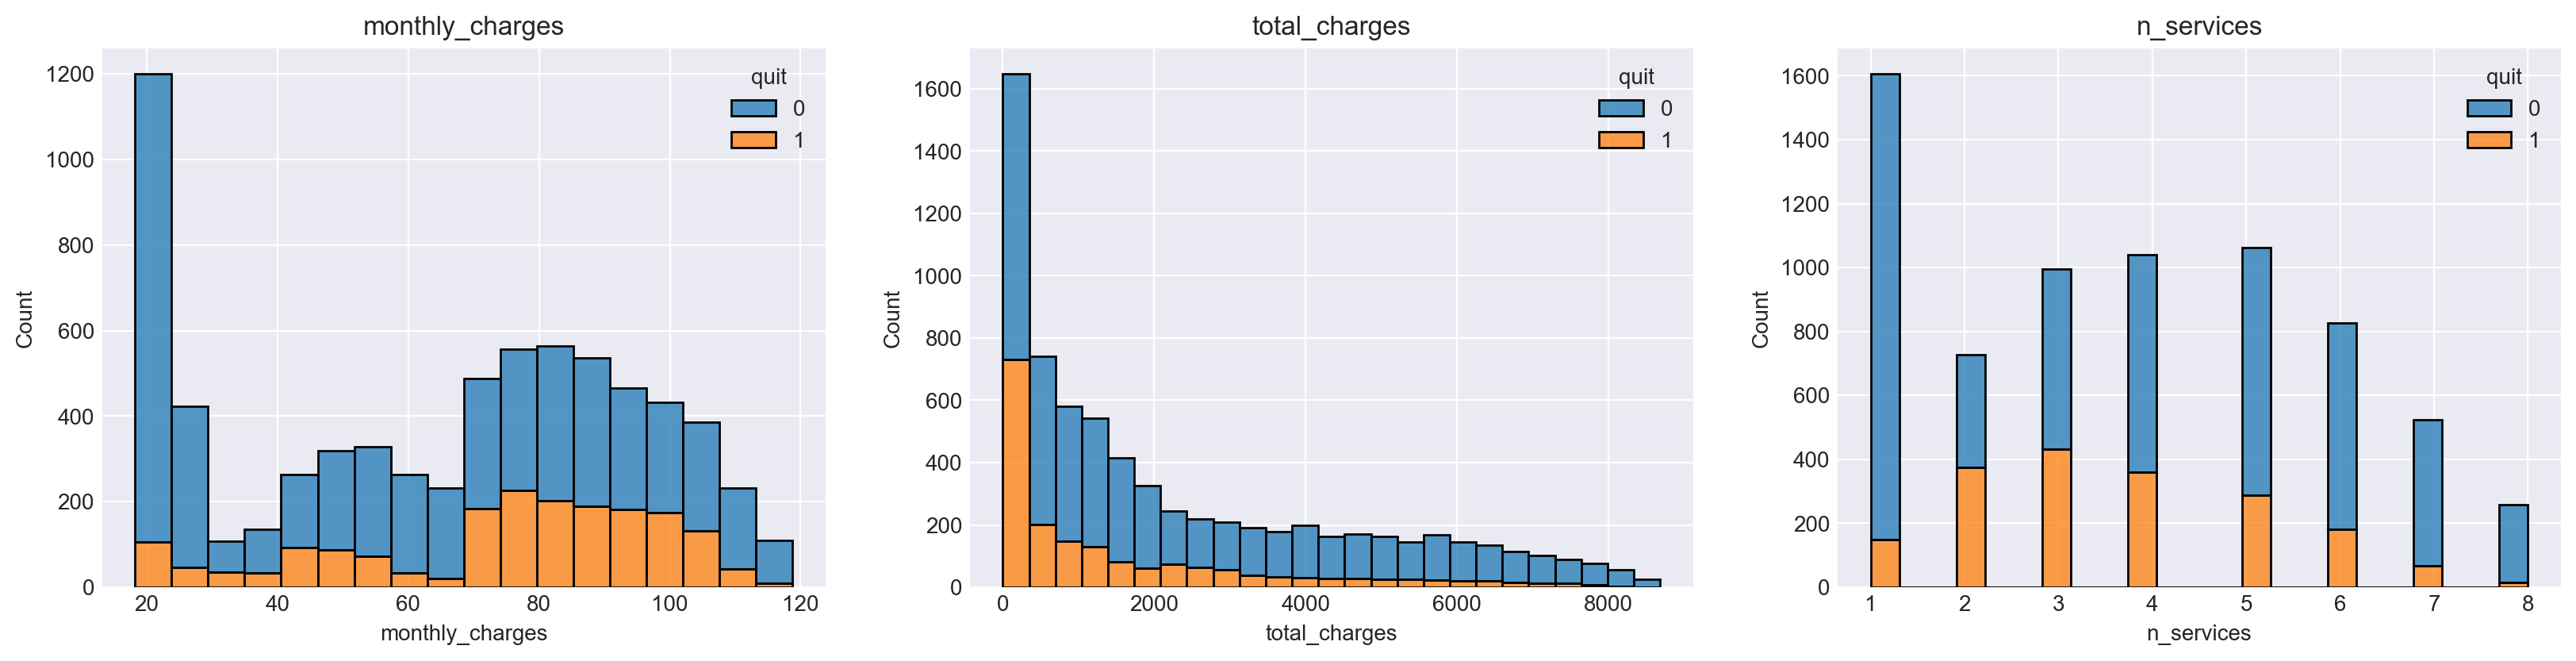

In [106]:
# plotting numerical features based on 'quit'
fig = plt.figure(figsize=(20, 15))

for n, col in enumerate(['monthly_charges', 'total_charges', 'n_services']):
    ax = plt.subplot(3, 3, n + 1)
    sns.histplot(df, x=col, hue='quit', multiple='stack')
    plt.title(col)

plt.show()

Let's see one by one:
- `monthly_charges` — generally speaking, the majority of users who maintain their contract have lower monthly charges.
- `total_charges` — clients who have a higher total charge are more likely to stay
- `n_services` — clients with 2, 3 or 4 services are more likely to quit.

Now, let's do the same but with categorical features:

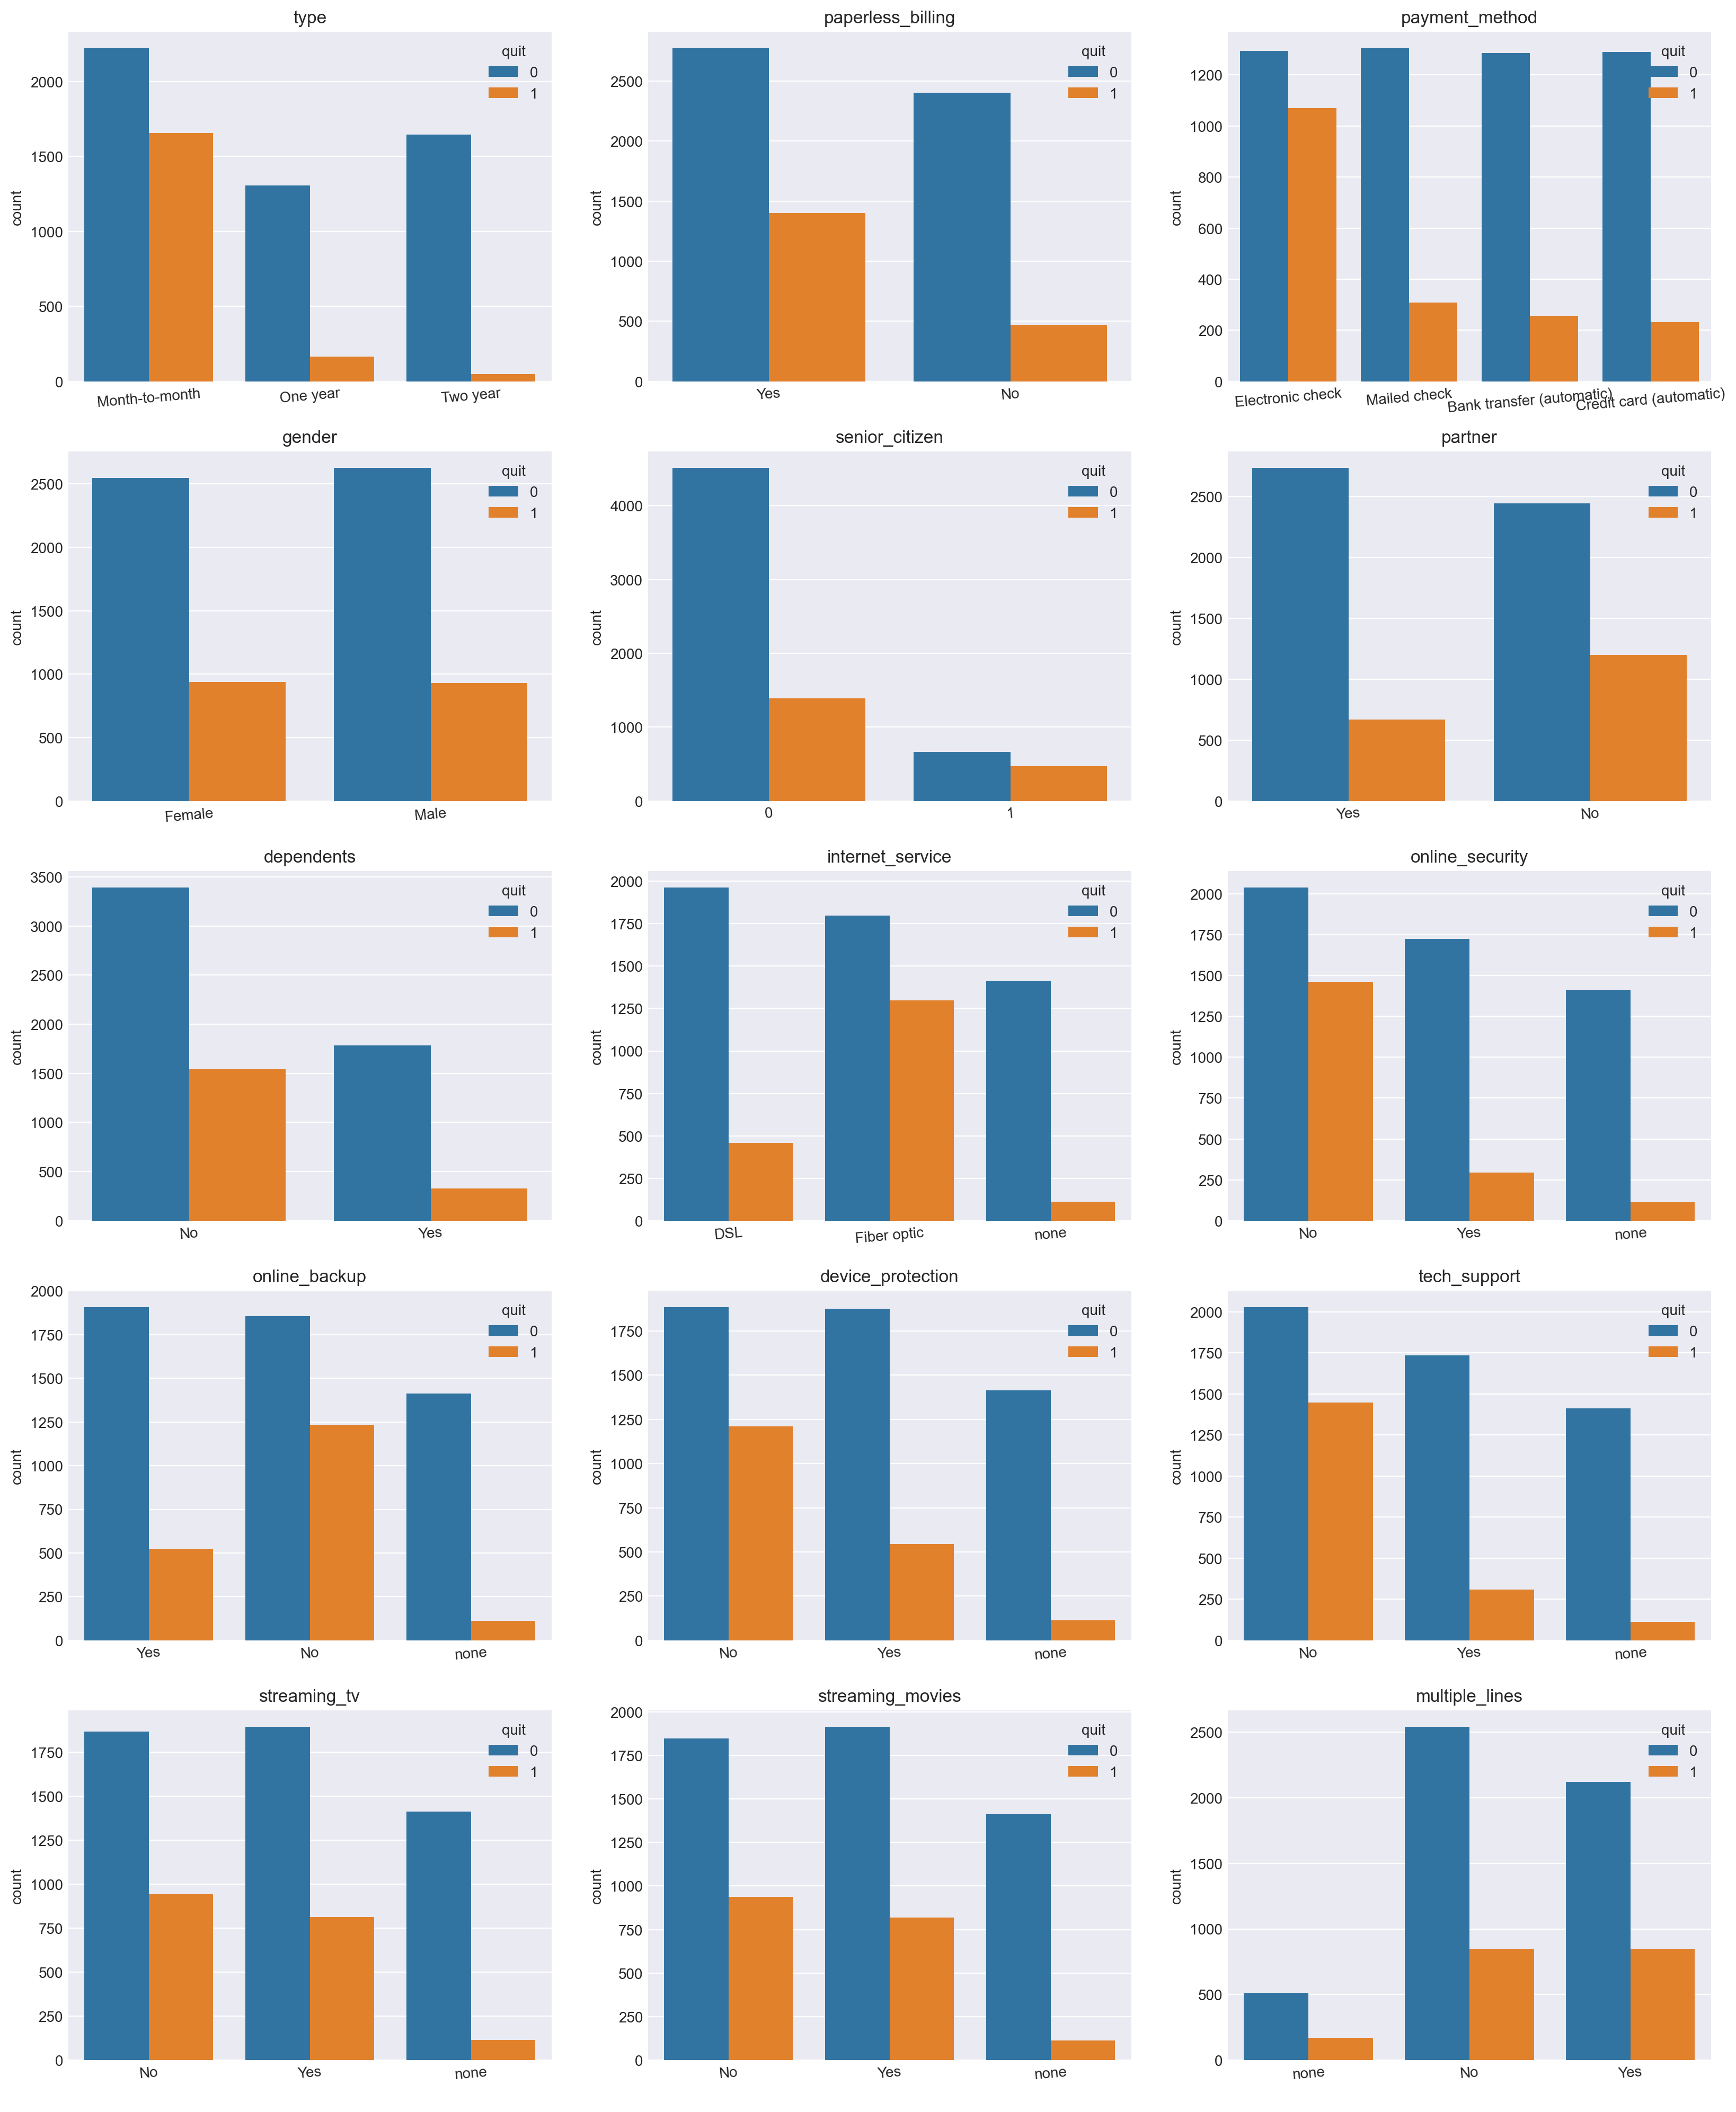

In [107]:
# plotting categorical features based on 'quit'
fig = plt.figure(figsize=(20, 30))

for n, col in enumerate(['type', 'paperless_billing', 'payment_method', 'gender', 
                         'senior_citizen', 'partner', 'dependents','internet_service', 
                         'online_security', 'online_backup', 'device_protection', 
                         'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']):
    ax = plt.subplot(6, 3, n + 1)
    sns.countplot(x=df[col], hue=df['quit'], ax=ax)
    plt.title(col)
    plt.xlabel(' ')
    plt.xticks(rotation=5)
    
plt.show()

The first thing that jump to the eyes is that for all features there is a bigger portion of clients that keep their contract. Let's see one by one:
- `type` — a higher number of customers with monthly payment quit their contract. Those who pay   year by year or every two-year are more likely to stay.
- `paperless_billing` — clients with paperless billing are more likely to quit 
- `payment_method` — clients with electronic check are more likely to quit
- `gender` — there is no much difference between male and female 
- `senior_citizen` — even there is a smaller portion of retired clients, these ones are more likely to leave
- `partner` — There are more partnered clients. But those with no partner are more likely to quit
- `dependents` — a higher portion of clients without employees quit their accounts.
- `internet_service` — clients with fiber optic are more likely to leave
- `online_security`, `online_backup`, `device_protection`, `tech_support`,`streaming_tv`, `streaming_movies`, — clients with no services are more likely to leave
- `multiple_lines` — in this case, both customers with single line or multiple lines have same probability to leave

Before training a model, it is a good practice to see what numerical features have more "weight" on the target, in our case the variable "quit". So we use a correlation matrix to do it:

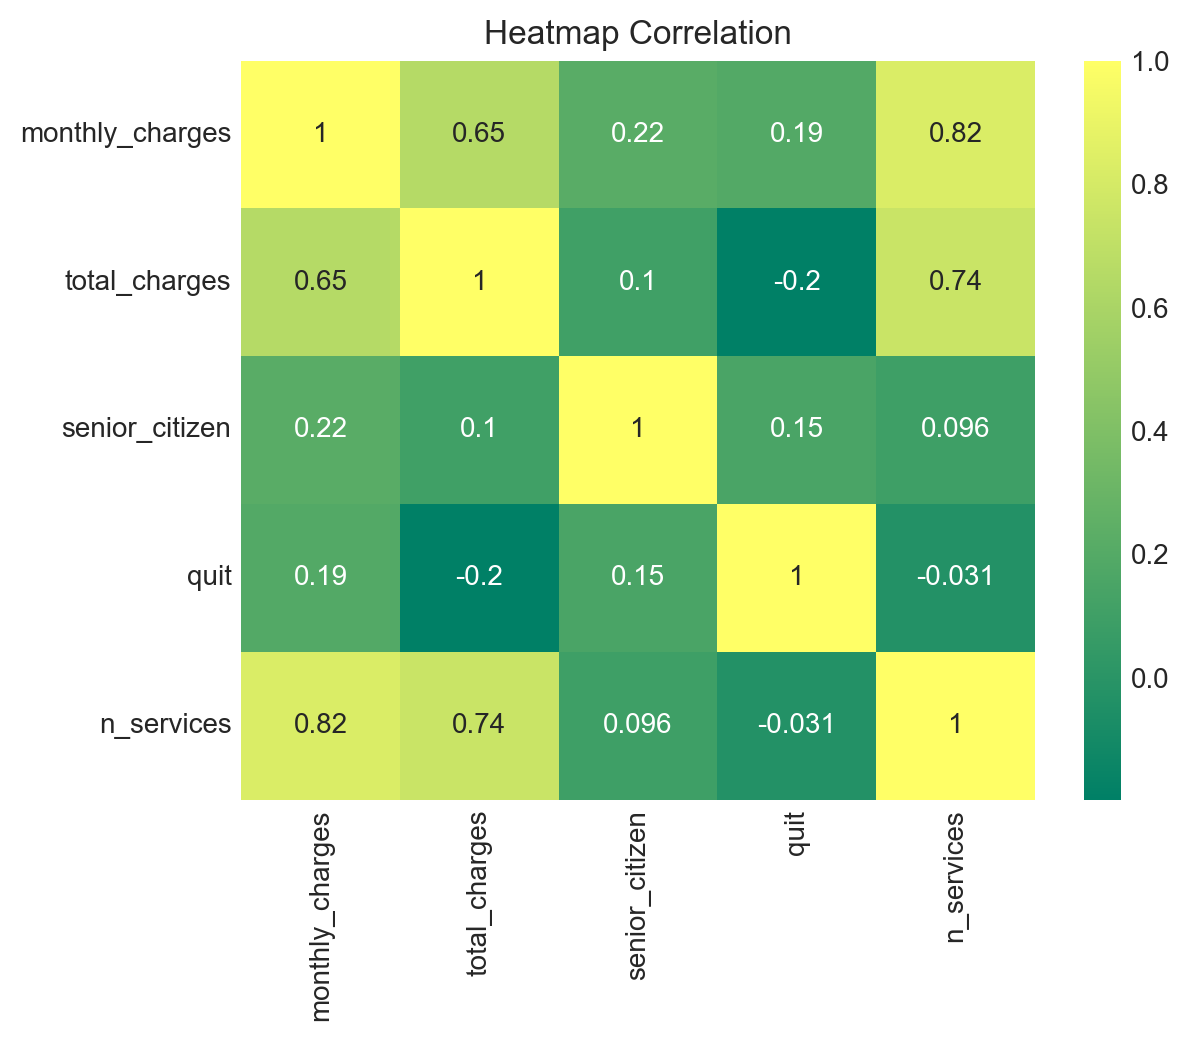

In [108]:
# plotting a heatmap correlation matrix
df_corr = df.drop(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'gender', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'], axis='columns')
sns.heatmap(df_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation')
plt.show()

There is no high correlation with any of the numerical features. There is a positive correlation between 'quit' and 'monthly charges' and 'senior_citizen' meaning that retired clients with high monthly charges are more likely to cancel their accounts. On the other hand, as we seen previously, there is a negative correlation between 'quit' and 'total_charges' meaning that the higher the latter, the less likely the client is willing to leave.

### 3.2 Target feature analysis <a id='3.2'></a>

Before training a model, it would be a good idea to verify if there is a class imbalance of the target feature "quit"

absolute quit
0    5174
1    1869
Name: quit, dtype: int64

relative quit
0    0.73
1    0.27
Name: quit, dtype: float64


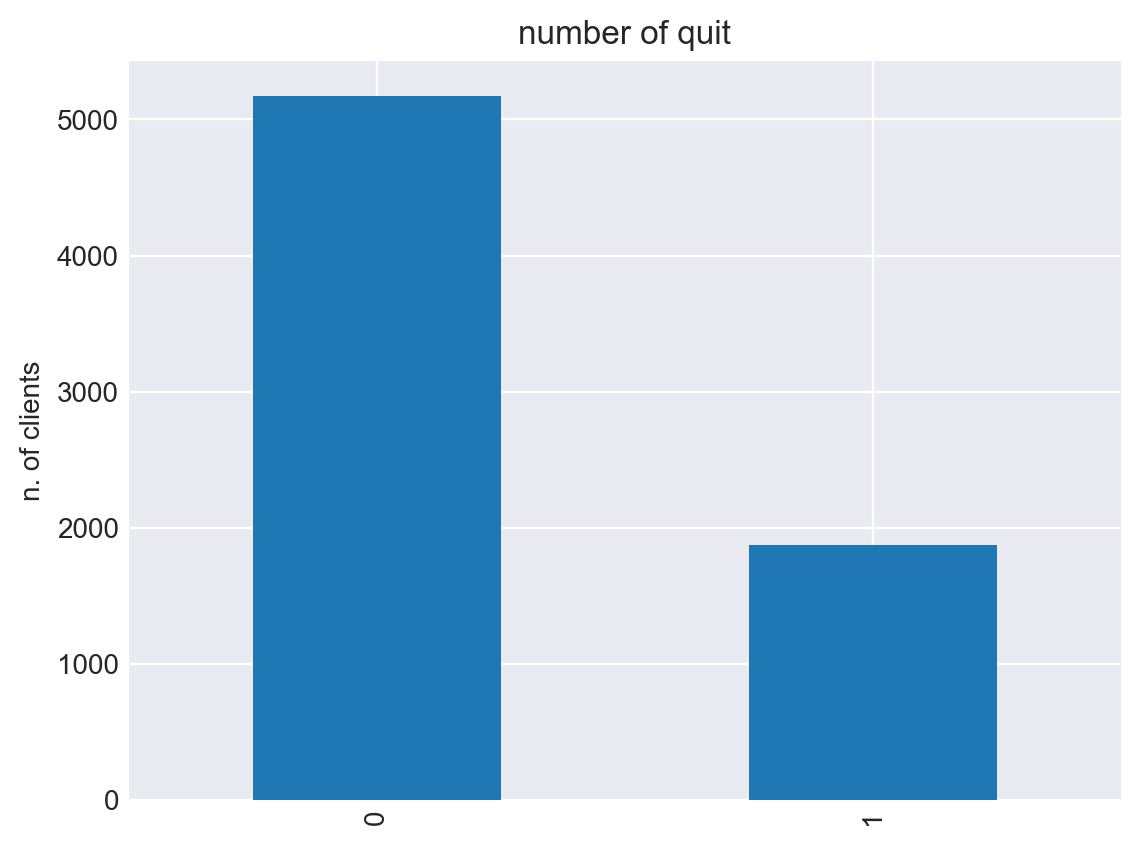

In [109]:
# printing the absolute number of clients who quit
print('absolute quit')
print(df['quit'].value_counts())

# printing the relative number of clients who quit
print('\nrelative quit')
print(df['quit'].value_counts(normalize=True).round(2))

# printing a bar chart
df['quit'].value_counts().plot(kind='bar', grid=True)
plt.title("number of quit")
plt.ylabel('n. of clients')
plt.show()

Indeed, there is a class imbalance. 73% of clients who did not leave the service and the other 26% who did. We will execute a oversampling to balance the classes

## Stage 4. Hypotesis testing<a id='4'></a>

Hypothesis are claims, and we can use statistics to prove or disprove them. So we can check whether or not the claims are valid. To test our hypothesis we will follow these points:
- state the null hypothesis (H0)
- state the alternative hypothesis (Ha)
- determine a significance level
- calculate the p-value
- draw conclusion

### 4.1 Test: equality of the averages monthly_charges for leaving and no-leaving customers <a id='4.1'></a>

The first claim is: The average monthly_charges for leaving and no-leaving customers are the same.

Lets set the Null Hypothesis (H0) and the Alternative Hypothesis (Ha):
- H0: no difference exist between the average monthly_charges for leaving and no-leaving customers
- Ha: a difference does exist between the average monthly_charges for leaving and no-leaving customers

We can assume a 90% of confidence level (meaning a 10% of significance level, α=10%) and so the question is: at α=10%, is there enough evidence to support the idea that the average monthly_charges for leaving csutomers is the same of no-leaving customers ?

In [110]:
# getting the two samples to compare
monthly_pay_quit = df.loc[df['quit'] == 1, ['monthly_charges']].values.tolist()
monthly_pay_stay = df.loc[df['quit'] == 0, ['monthly_charges']].values.tolist()

alpha = 0.10  # the level of critical statistical significance

results = st.ttest_ind(monthly_pay_quit, monthly_pay_stay, nan_policy='omit')

print('p-value: ', results.pvalue)

if results.pvalue < alpha:  # if the p-value is less than alpha, we reject the hypothesis
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value:  [2.70664561e-60]
We reject the null hypothesis


Rejecting the null hypotesis in this case means that, with a significance level of 10%, the statement "no difference exist between the average monthly_charges for leaving and no-leaving customers" is false. This does not necessarily mean that the alternative hypothesis is true.

Let's trace an histogram that resume the monthly_charges of both customers.

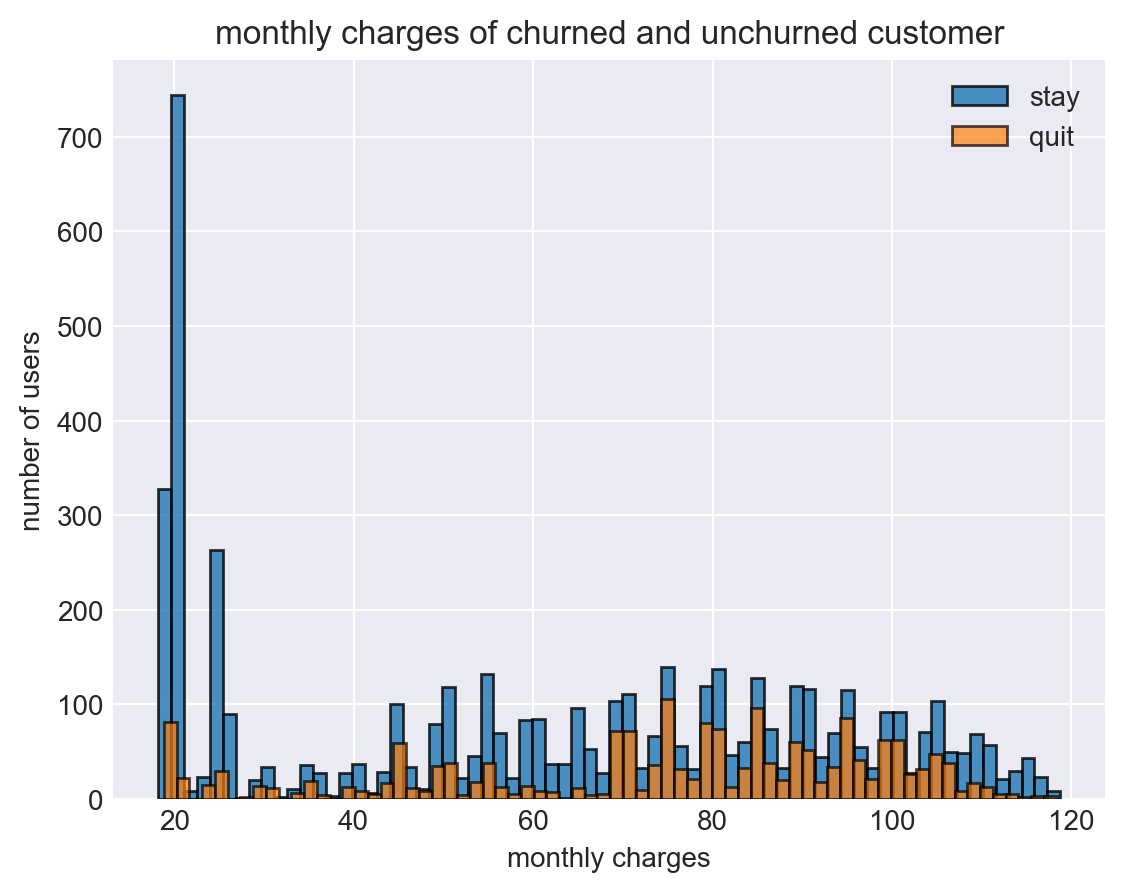

In [111]:
plt.hist(df.loc[df['quit'] == 0, ['monthly_charges']], edgecolor = 'black', bins=70, alpha = 0.8, label= 'stay')
plt.hist(df.loc[df['quit'] == 1, ['monthly_charges']], edgecolor = 'black', bins=70, alpha = 0.7, label= 'quit')
plt.title('monthly charges of churned and unchurned customer')
plt.legend(loc='upper right')
plt.xlabel('monthly charges')
plt.ylabel('number of users')
plt.show()

Let's plot now a probability density function for monthly_charges of both customers.

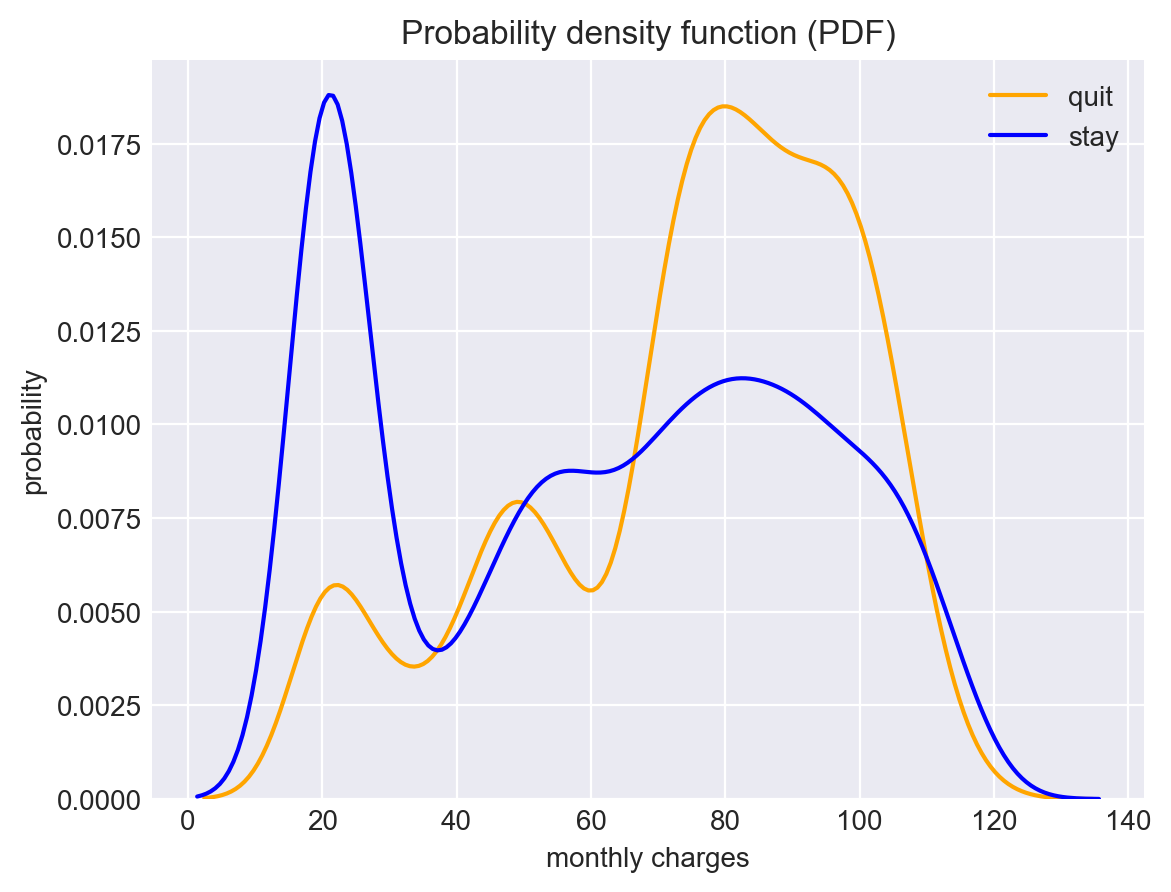

In [112]:
sns.kdeplot(data = df.loc[df['quit'] == 1, ['monthly_charges']], x='monthly_charges', color='orange', label='quit')
sns.kdeplot(data = df.loc[df['quit'] == 0, ['monthly_charges']], x='monthly_charges', color='blue', label='stay')
plt.legend()
plt.title('Probability density function (PDF)')
plt.xlabel('monthly charges')
plt.ylabel('probability')
plt.show()

### 4.2 Test: inequality of the averages total_charges for leaving and no-leaving customers <a id='4.2'></a>

The second claim is: The average total_charges for leaving and no-leaving customers is different.

Lets set the Null Hypothesis (H0) and the Alternative Hypothesis (Ha):
- H0: no difference exist between the average total_charges for leaving and no-leaving customers
- Ha: a difference does exist between the average total_charges for leaving and no-leaving customers

We can assume a 90% of confidence level (meaning a 10% of significance level, α=10%) and so the question is: at α=10%, is there enough evidence to support the idea that the average total_charges for leaving csutomers is the same of no-leaving customers ?

In [113]:
# getting the two samples to compare
total_pay_quit = df.loc[df['quit'] == 1, ['total_charges']].values.tolist()
total_pay_stay = df.loc[df['quit'] == 0, ['total_charges']].values.tolist()

alpha = 0.10  # the level of critical statistical significance

results = st.ttest_ind(total_pay_quit, total_pay_stay, nan_policy='omit')

print('p-value: ', results.pvalue)

if results.pvalue < alpha:  # if the p-value is less than alpha, we reject the hypothesis
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value:  [2.12721161e-63]
We reject the null hypothesis


Rejecting the null hypotesis in this case means that, with a significance level of 10%, the statement "no difference exist between the average total_charges for leaving and no-leaving customers" is false. This does not necessarily mean that the alternative hypothesis is true.

Let's trace an histogram that resume the total_charges of both customers.

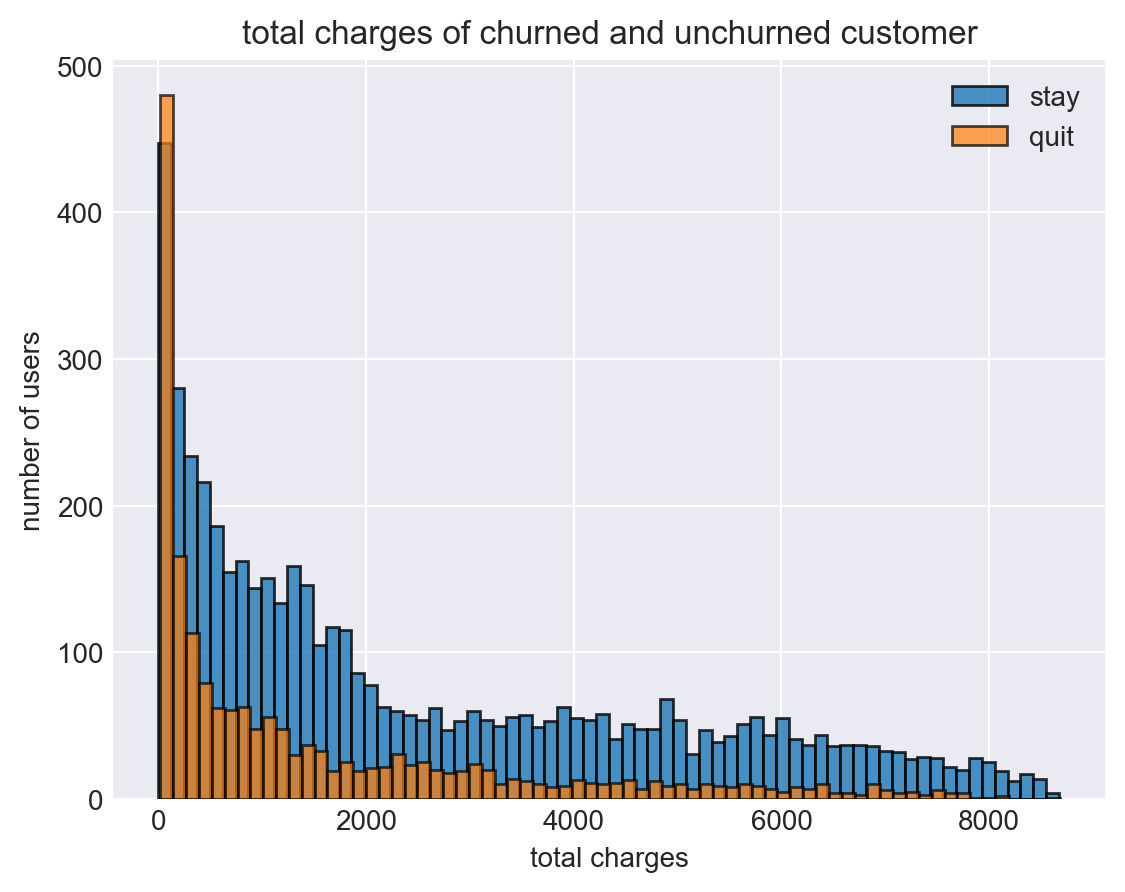

In [114]:
plt.hist(df.loc[df['quit'] == 0, ['total_charges']], edgecolor = 'black', bins=70, alpha = 0.8, label= 'stay')
plt.hist(df.loc[df['quit'] == 1, ['total_charges']], edgecolor = 'black', bins=70, alpha = 0.7, label= 'quit')
plt.title('total charges of churned and unchurned customer')
plt.legend(loc='upper right')
plt.xlabel('total charges')
plt.ylabel('number of users')
plt.show()

Let's plot now a probability density function for monthly_charges of both customers.

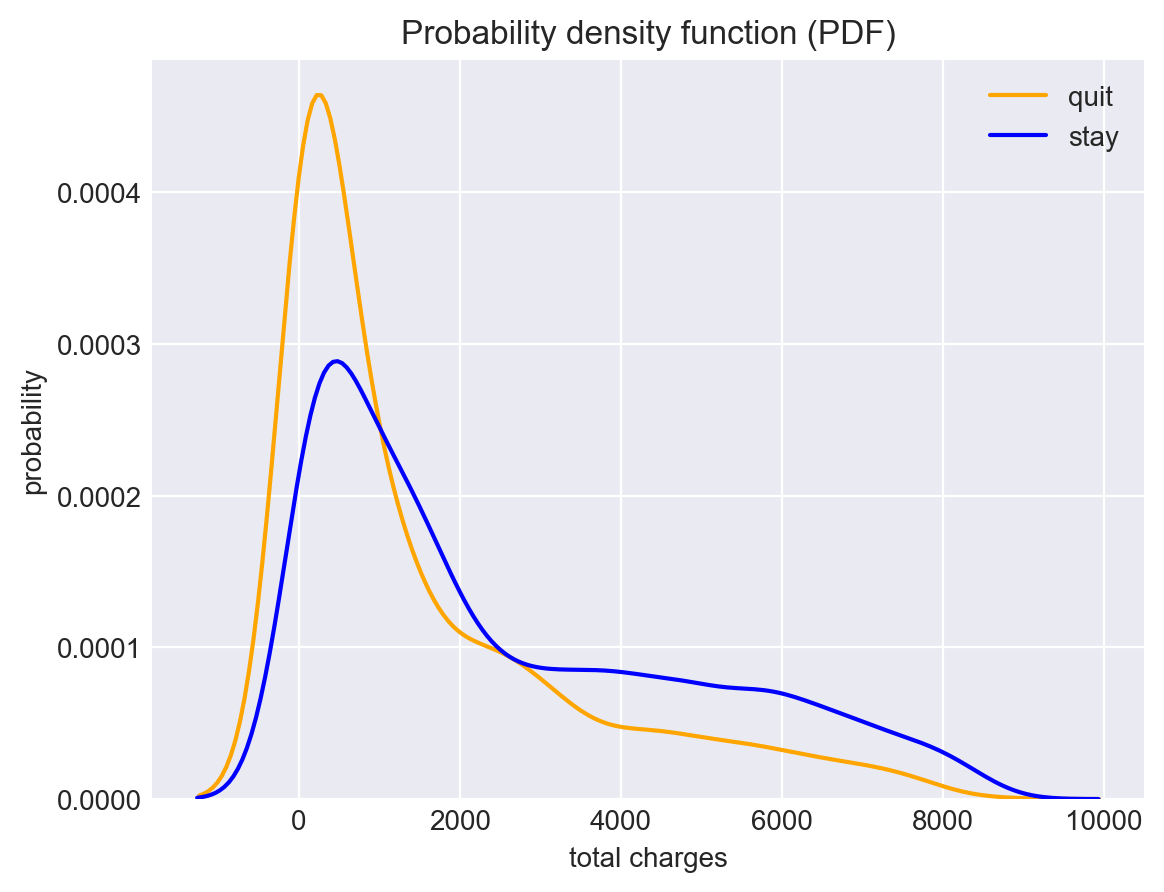

In [115]:
sns.kdeplot(data = df.loc[df['quit'] == 1, ['total_charges']], x='total_charges', color='orange', label='quit')
sns.kdeplot(data = df.loc[df['quit'] == 0, ['total_charges']], x='total_charges', color='blue', label='stay')
plt.legend()
plt.title('Probability density function (PDF)')
plt.xlabel('total charges')
plt.ylabel('probability')
plt.show()

### 4.3 Recap <a id='4.3'></a>

So far, we have extracted data and preprocessed them. We performed an exploratory data analysis (EDA). Now we will prepare data for model training and eventually execute different machine learning models with the aim of predicting the customers churn.

## Stage 5. Preparation for model training <a id='5'></a>

Since we have a target feature that can assume only two values, we deal with a supervised machine learning model for binary classification. We will train multiple models in order to reach what was asked from the company: AUC-ROC ≥ 0.88 .
The company also asked for the highest accuracy but we will see it once we find the best AUC-ROC model. Let's remove the unnecessary features first:

In [116]:
# removing unnecessary features
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
df.shape

(7043, 19)

### 5.1 Data upsampling <a id='5.1'></a>

Let's set a function for oversampling. We will use it later.

In [117]:
# upsampling function
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_ups = pd.concat([features_zeros] + [features_ones] * repeat)
    target_ups = pd.concat([target_zeros] + [target_ones] * repeat)
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=12345)
    
    return features_ups, target_ups

### 5.2 Data encoding - OHE <a id='5.2'></a>

Since our dataframe contains categorical features, we are going to use the One Hot Encoding technique to transform categorical features into numerical. Once we encoded all categorical features, we have to split, upsample and standardize the numerical features of the dataset. This because they are expressed by different ranges of absolute numbers.

In [118]:
# creating a new dataframe using OHE
df_ohe = pd.get_dummies(df, drop_first=True)

What we are going to do now is splitting our dataframes (df_ohe) in 3 sets:
- training set (3/5 of the data)
- test set (1/5 of the data)
- validation set (1/5 of the data)

In [119]:
# Splitting training set from test set (60/40)
df_train_ohe, df_test_ohe = train_test_split(df_ohe, test_size = 0.20, random_state=12345)

In [120]:
print('Size of the training set "df_train_ohe" is:', df_train_ohe.shape)
print('Size of the test set "df_test_ohe" is:', df_test_ohe.shape)

Size of the training set "df_train_ohe" is: (5634, 30)
Size of the test set "df_test_ohe" is: (1409, 30)


In [121]:
# declaring features(X) and target(Y) for every set
X_train_ohe = df_train_ohe.drop('quit', axis=1)
Y_train_ohe = df_train_ohe['quit']

X_test_ohe = df_test_ohe.drop('quit', axis=1)
Y_test_ohe = df_test_ohe['quit']

Now we use the upsampling technique to balance our data

In [122]:
# upsamplimg OHE 
X_train_ohe_ups, Y_train_ohe_ups = upsample(X_train_ohe, Y_train_ohe, 3)
X_test_ohe_ups, Y_test_ohe_ups = upsample(X_test_ohe, Y_test_ohe, 3)

In [123]:
# scaling numerical features
scaler = StandardScaler()
num_features = ['monthly_charges', 'total_charges', 'n_services']
scaler.fit(X_train_ohe_ups[num_features])

X_train_ohe_ups[num_features] = scaler.transform(X_train_ohe_ups[num_features])
X_test_ohe_ups[num_features] = scaler.transform(X_test_ohe_ups[num_features])

### 5.3 Data encoding - OrdinalEncoder <a id='5.3'></a>

Since the OHE technique is not the best one when working on tree based models, we will also encode with OrdinalEncoder:

In [124]:
df_ordin = df.copy()

# encoding categorical features with OrdinalEncoder
encoder = OrdinalEncoder()
cat_features = ['type', 'paperless_billing',
       'payment_method', 'gender', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']
df_ordin[cat_features] = pd.DataFrame(encoder.fit_transform(df_ordin[cat_features]))

In [125]:
# Splitting training set from test set (60/40)
df_train_ordin, df_test_ordin = train_test_split(df_ordin, test_size = 0.20, random_state=12345)

In [126]:
print('Size of the training set "df_train_ordin" is:', df_train_ordin.shape)
print('Size of the test set "df_test_ordin" is:', df_test_ordin.shape)

Size of the training set "df_train_ordin" is: (5634, 19)
Size of the test set "df_test_ordin" is: (1409, 19)


In [127]:
# declaring features(X) and target(Y) for every set
X_train_ordin = df_train_ordin.drop('quit', axis=1)
Y_train_ordin = df_train_ordin['quit']

X_test_ordin = df_test_ordin.drop('quit', axis=1)
Y_test_ordin = df_test_ordin['quit']

Now we use the upsampling technique to balance our data

In [128]:
# upsamplimg OrdinalEncoder
X_train_ordin_ups, Y_train_ordin_ups = upsample(X_train_ordin, Y_train_ordin, 3)
X_test_ordin_ups, Y_test_ordin_ups = upsample(X_test_ordin, Y_test_ordin, 3)

In [129]:
# Fit the scaler to data and transform it
X_train_ordin_ups = scaler.fit_transform(X_train_ordin_ups)
X_test_ordin_ups = scaler.transform(X_test_ordin_ups)

### 5.4 Evaluating function <a id='5.4'></a>

In order to evaluate the performance of machine learning models, we will build the 'evaluate_model' function that allows us to compose an evaluation routine that can be used for all the models in this project.

In [130]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    '''
this function returns the values for accuracy, average precision, F1 score, and ROC-AUC.
It also returns ROC-AUC, F1 and PRC (precision-recall curve) curve plots
    
:model: model pretrained and with hyperparameter tuning
:train_features: training features
:train_target: training features
:test_features: testing target
:test_target: testing target
    
    '''    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 value
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # set some thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 value') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # set some thresholds         
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # set some thresholds       
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[type]['Precision'] = metrics.precision_score(target, pred_target)
        eval_stats[type]['Recall'] = metrics.recall_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'Recall', 'Precision', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [190]:
# Create a data frame named "summary_models" where we save information of different models
summary_models = pd.DataFrame(columns=['model', 'roc_auc_train', 'roc_auc_test', 'accuracy_train', 'accuracy_test', 'training_time'])

## Stage 6. Model training <a id='6'></a>

Now that we have established our training and test set, let's continue with the training of machine learning models. We will evaluate the performance of each model through the AUC-ROC value with the 'evaluate_model' function. The goal is AUC-ROC ≥ 0.88.

### 6.1 Model_0 - DummyClassifier <a id='6.1'></a>

We start performing a sanity check. For this we will use a DummyClassifier model that will predict the most frequent class, which is zero.

In [151]:
# set the features and target of dummy model
X = df.drop('quit', axis=1)
Y = df['quit']

# splitting training set and test set (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=12345)

training time = 0.00 sec

           train   test
Accuracy   0.736  0.731
Recall     0.000  0.000
Precision  0.000  0.000
F1         0.000  0.000
APS        0.264  0.269
ROC AUC    0.500  0.500


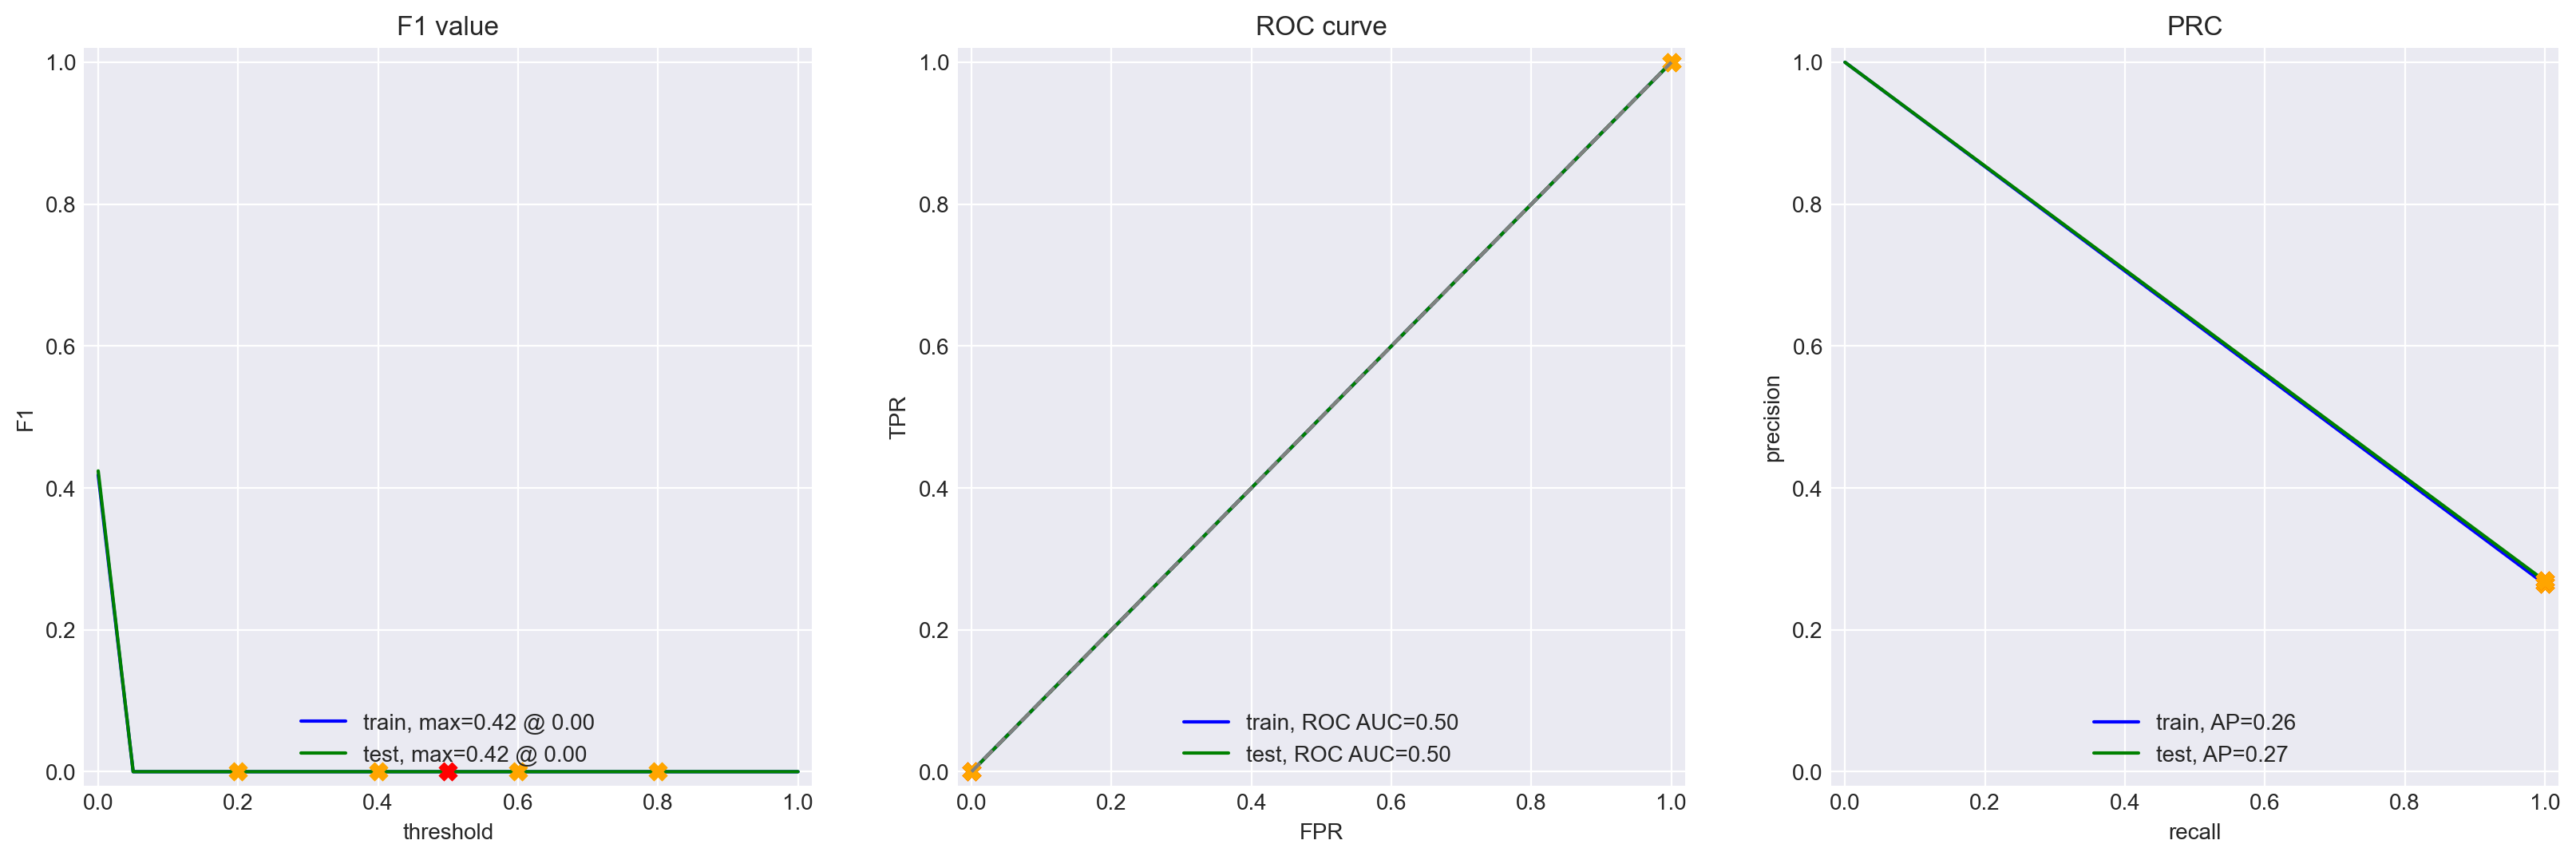

In [156]:
# calling DummyClassifier with strategy 'constant' and train it
dummy_model = DummyClassifier(strategy='constant', constant=0)

start_time = time.time()
dummy_model.fit(X_train, Y_train)
train_time = time.time() - start_time
print('training time = 'f'{train_time:.2f} sec\n')

# evaluating the model by calling the function 'evaluate_model'
evaluate_model(dummy_model, X_train, Y_train, X_test, Y_test)

The graph on the left says that for a model to be considered better than a random one, it should just have F1 > 0. At the same time the values of the ROC-AUC metrics must be greater than 0.5.

In [191]:
# Save info
model = {'model': 'DummyClassifier',
        'roc_auc_train': 0.5, 
        'roc_auc_test':0.5, 
        'accuracy_train':0.736,
        'accuracy_test':0.731,
        'training_time': 0}

summary_models = summary_models.append(model, ignore_index = True)

### 6.2 Model_1 - DecisionTree <a id='6.2'></a>

Let's train the model using DecisionTree technique. We first find the best hyperparameters and than we use them to evaluate the model. We use the parameter class_weight='balanced' to adjust the class imbalance.

In [132]:
# set DecisionTree hyperparameters
parameters_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 8, 10]
}
# calling GridSearchCV and pass the model, hyperparameters, ROC-AUC metric and cross validation
dec_tree = GridSearchCV(DecisionTreeClassifier(random_state = 12345, class_weight='balanced'),
                        param_grid=parameters_dt,
                        scoring='roc_auc',
                        cv=5
                        )

start_time = time.time()
dec_tree.fit(X_train_ordin, Y_train_ordin)
train_time = time.time() - start_time

print(f'Best hyperparameters DecisionTree: {dec_tree.best_params_}')
print(f'Best ROC-AUC value DecisionTree: {dec_tree.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters DecisionTree: {'criterion': 'entropy', 'max_depth': 5}
Best ROC-AUC value DecisionTree: 0.823
training time = 0.76 sec


           train   test
Accuracy   0.768  0.754
Recall     0.756  0.739
Precision  0.787  0.781
F1         0.772  0.759
APS        0.830  0.805
ROC AUC    0.849  0.823


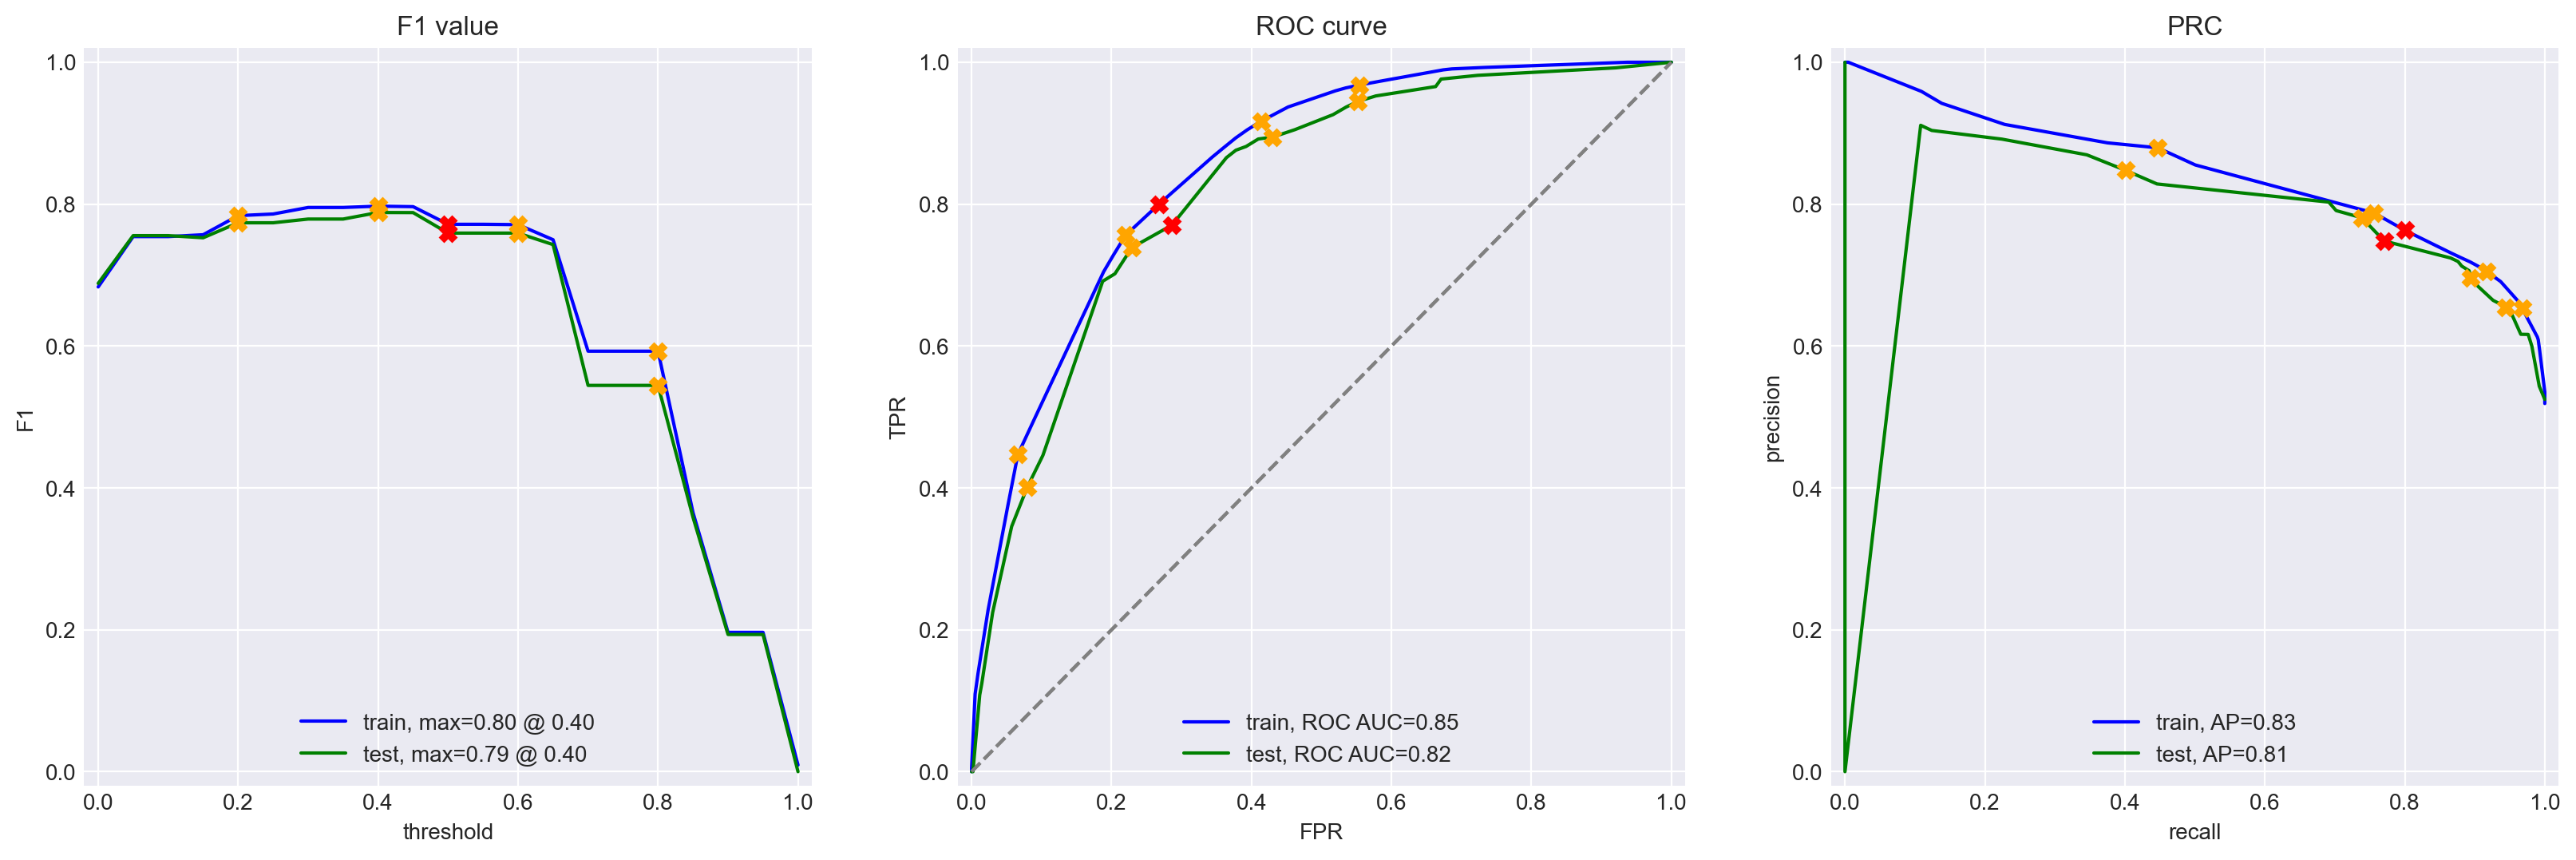

In [133]:
# train DecisionTree model with the best hyperparameters
model_dt = DecisionTreeClassifier(random_state=12345, criterion='entropy', max_depth=5)
model_dt.fit(X_train_ordin_ups, Y_train_ordin_ups)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_dt, X_train_ordin_ups, Y_train_ordin_ups, X_test_ordin_ups, Y_test_ordin_ups)

For the DecisionTreeClassifier model, F1 is higher than the DummyClassifier. The ROC-AUC metric in the test set is 0.82 and in the training set 0.85, so there is a light overfit. Anyway, DecTreeClass model does not reach the desired ROC-AUC performance.

In [192]:
# Save info
model = {'model': 'DecisionTreeClassifier',
        'roc_auc_train': 0.849, 
        'roc_auc_test':0.823, 
        'accuracy_train':0.768,
        'accuracy_test':0.754,
        'training_time': 0.76}

summary_models = summary_models.append(model, ignore_index = True)

### 6.3 Model_2 - RandomForest <a id='6.3'></a>

Let's train the model using RandomForestClassifier technique. We first find the best hyperparameters and than we use them to evaluate the model. We use the parameter class_weight='balanced' to adjust the class imbalance.

In [134]:
# set RandomForest hyperparameters
parameters_rf = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [10, 20, 40, 50],
    'max_depth': [2, 4, 6, 8, 10]
}

# calling GridSearchCV and pass the model, hyperparameters, ROC-AUC metric and cross validation
rand_for = GridSearchCV(RandomForestClassifier(random_state=12345, class_weight='balanced'),
                        param_grid=parameters_rf,
                        scoring='roc_auc',
                        cv=5
                        )

start_time = time.time()
rand_for.fit(X_train_ordin, Y_train_ordin)
train_time = time.time() - start_time

print(f'Best hyperparameters RandomForest: {rand_for.best_params_}')
print(f'Best ROC-AUC value RandomForest: {rand_for.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters RandomForest: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 40}
Best ROC-AUC value RandomForest: 0.843
training time = 18.50 sec


           train   test
Accuracy   0.788  0.767
Recall     0.854  0.839
Precision  0.764  0.748
F1         0.807  0.791
APS        0.860  0.834
ROC AUC    0.867  0.841


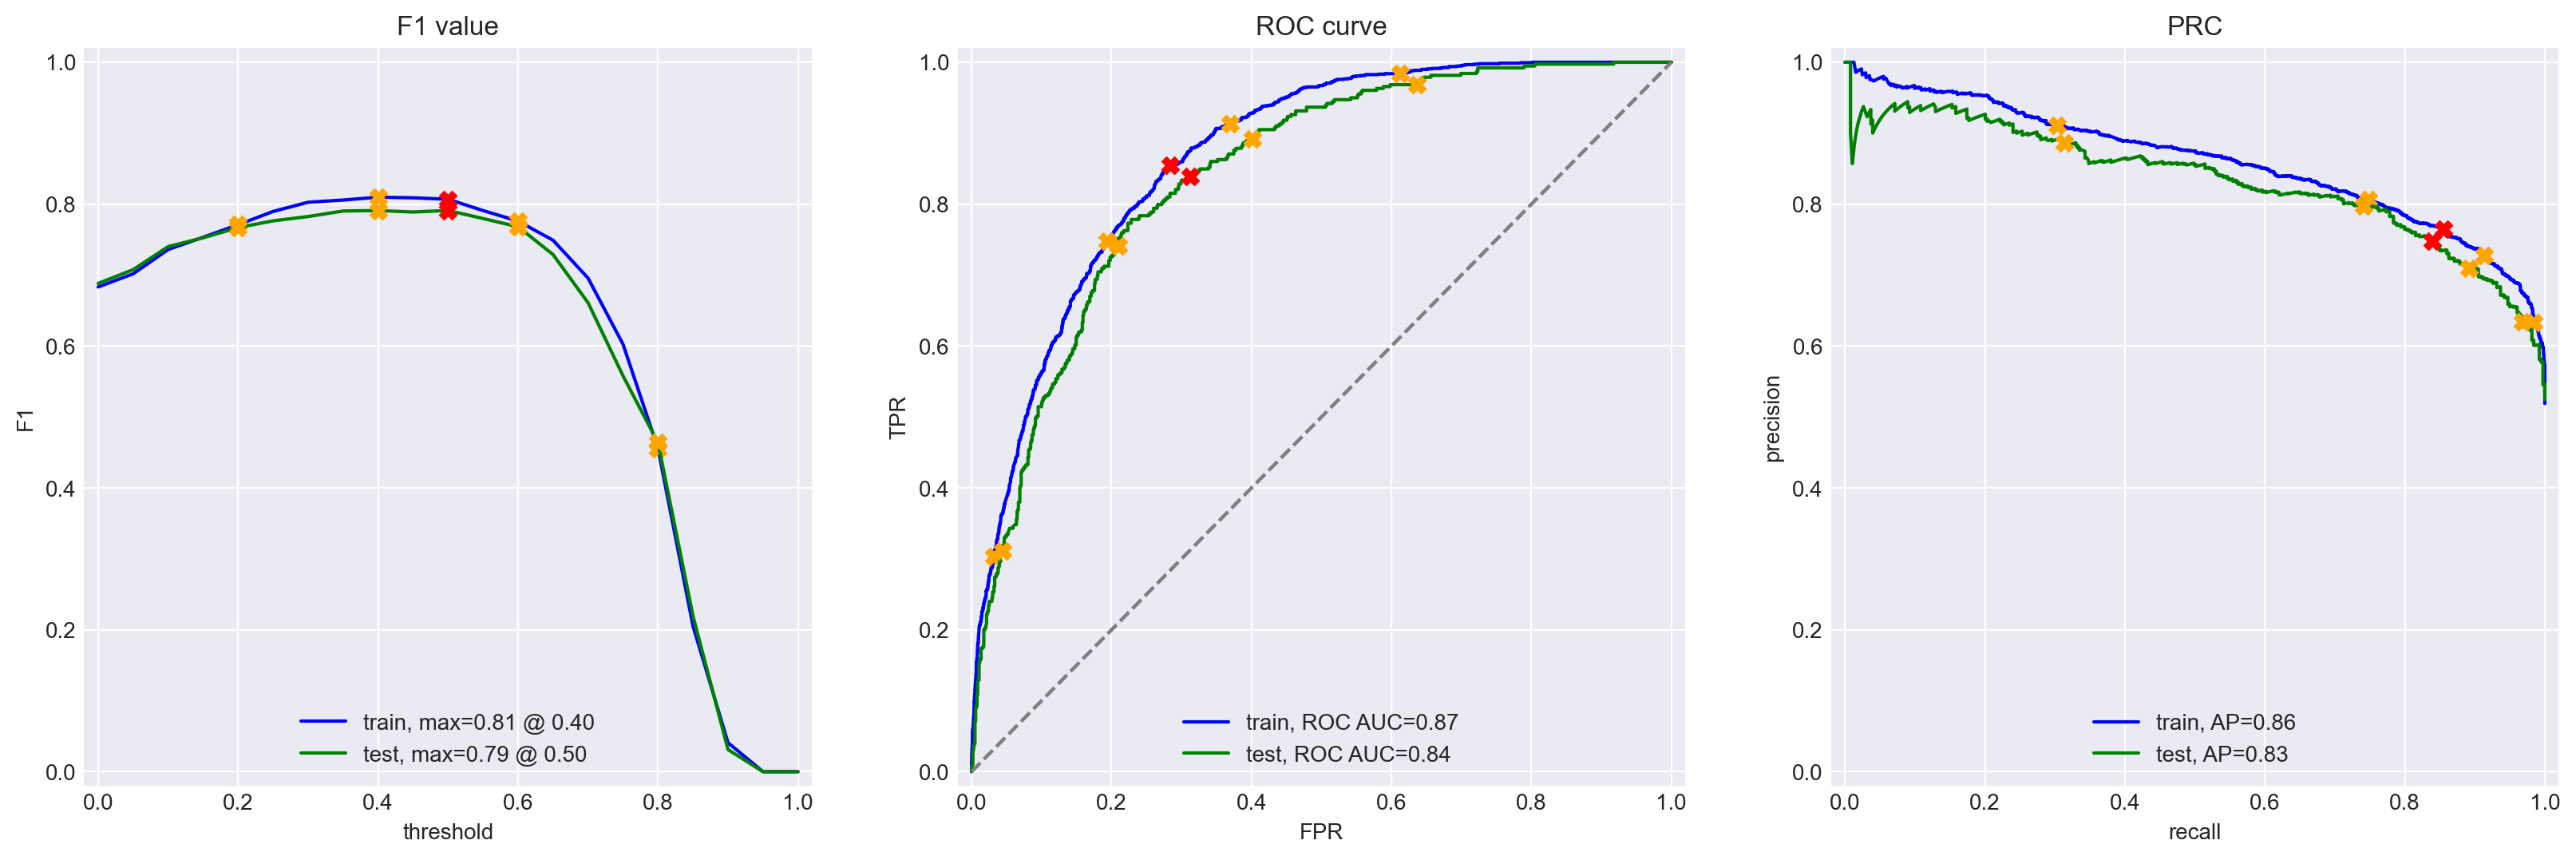

In [135]:
# train RandomForest model with the best hyperparameters
model_rf = RandomForestClassifier(random_state=12345, criterion= 'entropy', max_depth=6, n_estimators=40)
model_rf.fit(X_train_ordin_ups, Y_train_ordin_ups)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_rf, X_train_ordin_ups, Y_train_ordin_ups, X_test_ordin_ups, Y_test_ordin_ups)

The ROC-AUC metric reached 0.87 in train set and 0.84 in test set. It is slightly higher than the previous ones, however there is still overfit. RandForestClass does not reach the desired ROC-AUC.

In [195]:
# Save info
model = {'model': 'RandomForestClassifier',
        'roc_auc_train': 0.867, 
        'roc_auc_test':0.841, 
        'accuracy_train':0.788,
        'accuracy_test':0.767,
        'training_time': 18.50}

summary_models = summary_models.append(model, ignore_index = True)

### 6.4 Model_3 - LogisticRegression <a id='6.4'></a>

Let's train the model using LogisticRegression technique. We first find the best hyperparameters and than we use them to evaluate the model.

In [136]:
# set different hyperparameters
params_lr = {
    'penalty' : ['l1','l2'], 
    'solver'  : ['liblinear', 'saga'],
    'C'       : [0.1, 1.0]
}

# calling GridSearchCV and pass the model, hyperparameters, ROC-AUC metric and cross validation
log_regr = GridSearchCV(LogisticRegression(random_state=12345, class_weight='balanced'),
                        param_grid=params_lr,
                        scoring='roc_auc',
                        cv=5
                        )

# train the model for hyperparameter fitting
start_time = time.time()
log_regr.fit(X_train_ohe, Y_train_ohe)
train_time = time.time() - start_time

# check the best hyperparameters and F1
print(f'Best hyperparameters LogisticRegression: {log_regr.best_params_}')
print(f'Best ROC-AUC value LogisticRegression: {log_regr.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC value LogisticRegression: 0.837
training time = 3.12 sec


           train   test
Accuracy   0.760  0.763
Recall     0.803  0.805
Precision  0.752  0.759
F1         0.777  0.781
APS        0.833  0.835
ROC AUC    0.840  0.840


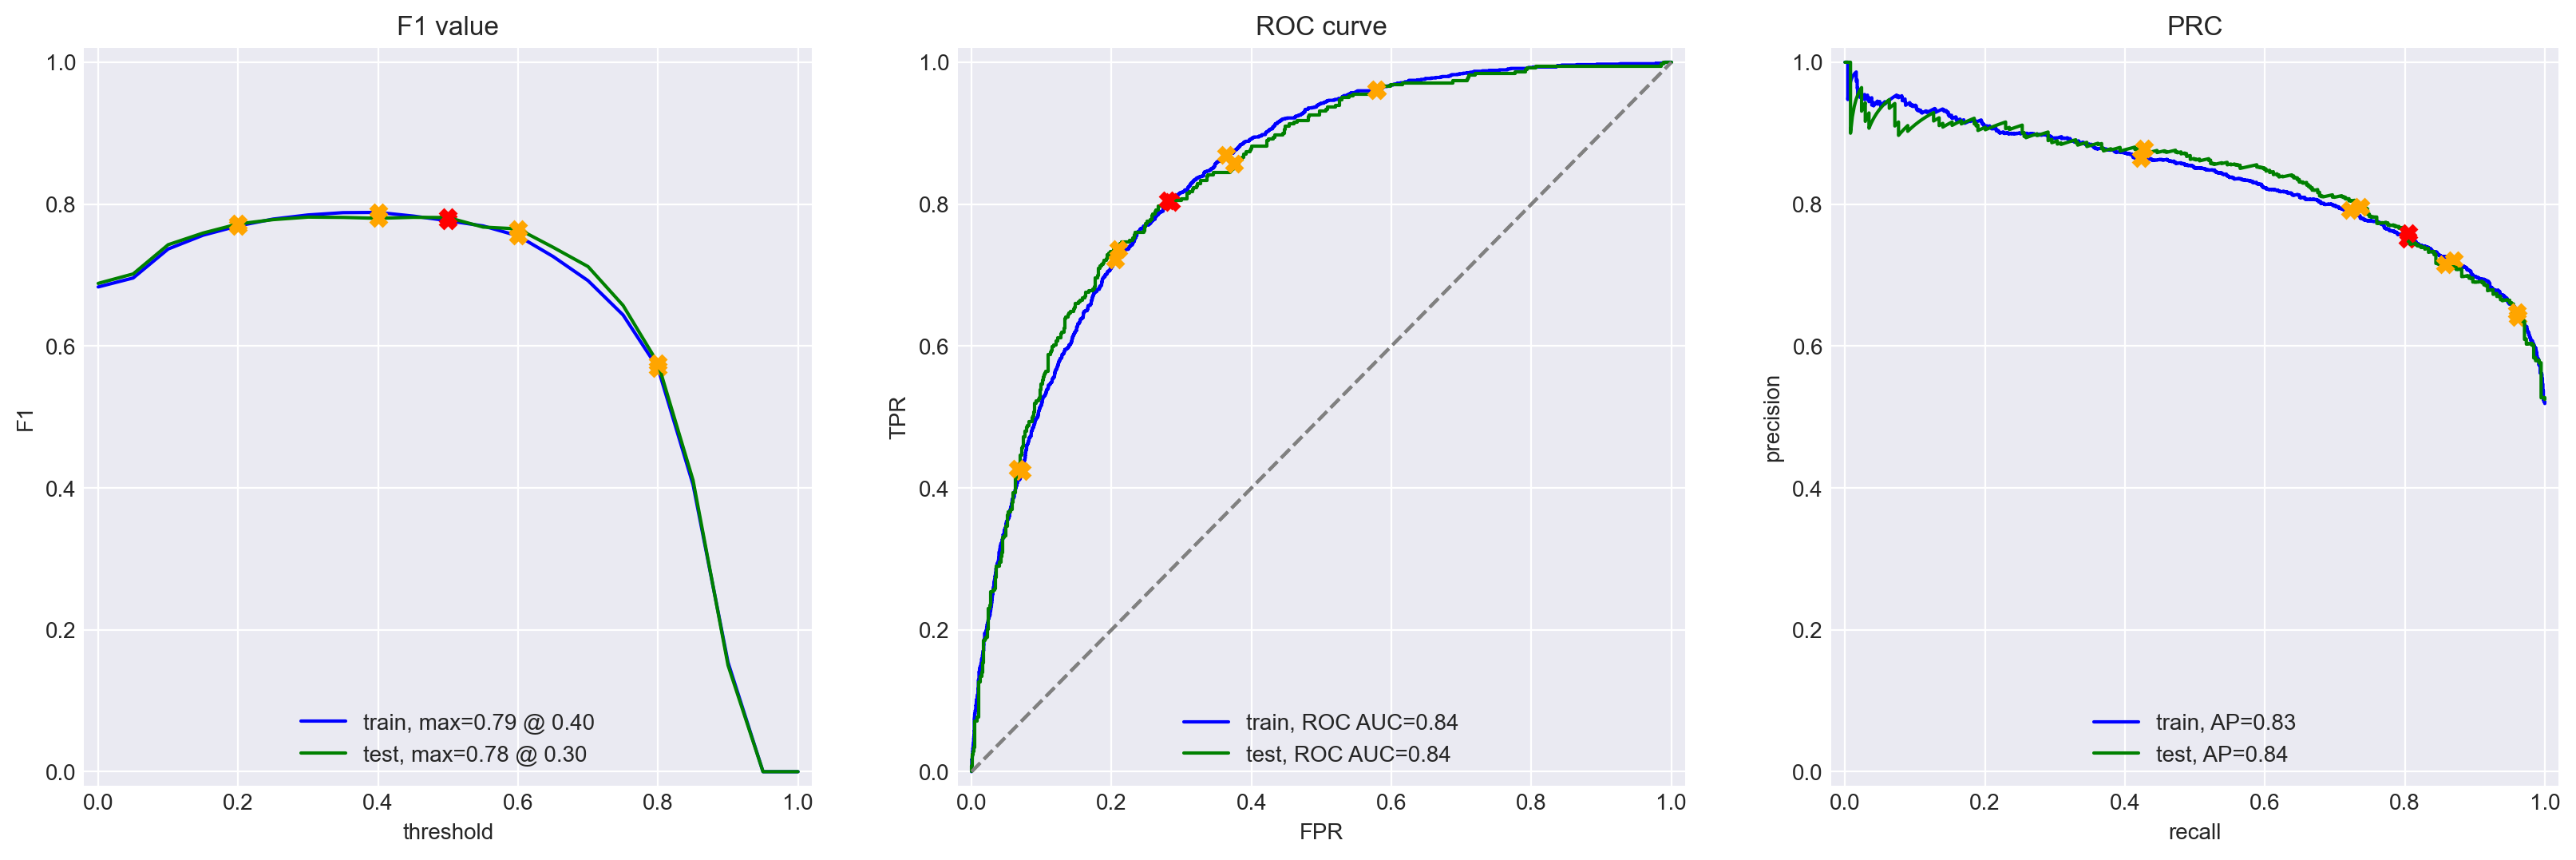

In [137]:
# train LogisticRegression model with the best hyperparameters
model_lr = LogisticRegression(random_state=12345, C= 0.1, penalty='l2', solver = 'liblinear')
model_lr.fit(X_train_ohe_ups, Y_train_ohe_ups)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_lr, X_train_ohe_ups, Y_train_ohe_ups, X_test_ohe_ups, Y_test_ohe_ups)

The ROC-AUC metric is 0.84 for both train and test set. It is almost the same of the previous ones. There is no overfit. We will use some gradient boosting techniques.

In [197]:
# Save info
model = {'model': 'LogisticRegression',
        'roc_auc_train': 0.840, 
        'roc_auc_test':0.840, 
        'accuracy_train':0.760,
        'accuracy_test':0.763,
        'training_time': 3.12}

summary_models = summary_models.append(model, ignore_index = True)

### 6.5 Model_4 - LGBMClassifier <a id='6.5'></a>

For LightGBM we will create a copy of the final dataset and convert the features from type 'object' to type 'category' so that they are correctly processed by the model. Then we standardize the numerical features with StandardScaler.

In [138]:
# make a copy of the final dataset
df_boost = df.copy()

# transform categorical features to type 'category'
for feature in cat_features:
    df_boost[feature] = df_boost[feature].astype('category')

In [139]:
# Splitting training set from test set (60/40)
df_train_boost, df_test_boost = train_test_split(df_boost, test_size = 0.20, random_state=12345)

In [140]:
print('Size of the training set "df_train_boost" is:', df_train_boost.shape)
print('Size of the test set "df_test_boost" is:', df_test_boost.shape)

Size of the training set "df_train_boost" is: (5634, 19)
Size of the test set "df_test_boost" is: (1409, 19)


In [141]:
# declaring features(X) and target(Y) for every set
X_train_boost = df_train_boost.drop('quit', axis=1)
Y_train_boost = df_train_ordin['quit']

X_test_boost = df_test_boost.drop('quit', axis=1)
Y_test_boost = df_test_boost['quit']

Now we use the upsampling technique to balance our data

In [142]:
# upsamplimg Boost 
X_train_boost_ups, Y_train_boost_ups = upsample(X_train_boost, Y_train_boost, 3)
X_test_boost_ups, Y_test_boost_ups = upsample(X_test_boost, Y_test_boost, 3)

For LGBM we do not necessarily need scaling our data but we write the code anyway

In [ ]:
# training the scaler with the upsampled X_train_boost
# scaler = StandardScaler()
# scaler.fit(X_train_boost_ups[num_features])

# scaling numerical features for every set
# X_train_boost_ups[num_features] = scaler.transform(X_train_boost_ups[num_features])
# X_test_boost_ups[num_features] = scaler.transform(X_test_boost_ups[num_features])
# X_valid_boost[num_features] = scaler.transform(X_valid_boost[num_features])

Now we look for the best hyperparameters to use in the prediction model. We use the parameter class_weight='balanced' to adjust the class imbalance.

In [170]:
# set different hyperparameters
params_lgbm = {
    'objective' : ['binary'], 
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [100] 
}

# calling GridSearchCV to get hyperparameters that maximize ROC-AUC
lightgbm = GridSearchCV(LGBMClassifier(random_state=12345, class_weight='balanced'),
                    param_grid=params_lgbm,
                    scoring='roc_auc',
                    cv=5
                    )

# train the model for hyperparameter fitting
start_time = time.time()
lightgbm.fit(X_train_boost, Y_train_boost)
train_time = time.time() - start_time

print(f'Best hyperparameters LightGBM: {lightgbm.best_params_}')
print(f'Best ROC-AUC value LightGBM: {lightgbm.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters LightGBM: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 10, 'objective': 'binary'}
Best ROC-AUC value LightGBM: 0.845
training time = 4.16 sec


           train   test
Accuracy   0.797  0.766
Recall     0.852  0.823
Precision  0.779  0.753
F1         0.813  0.787
APS        0.869  0.838
ROC AUC    0.875  0.845


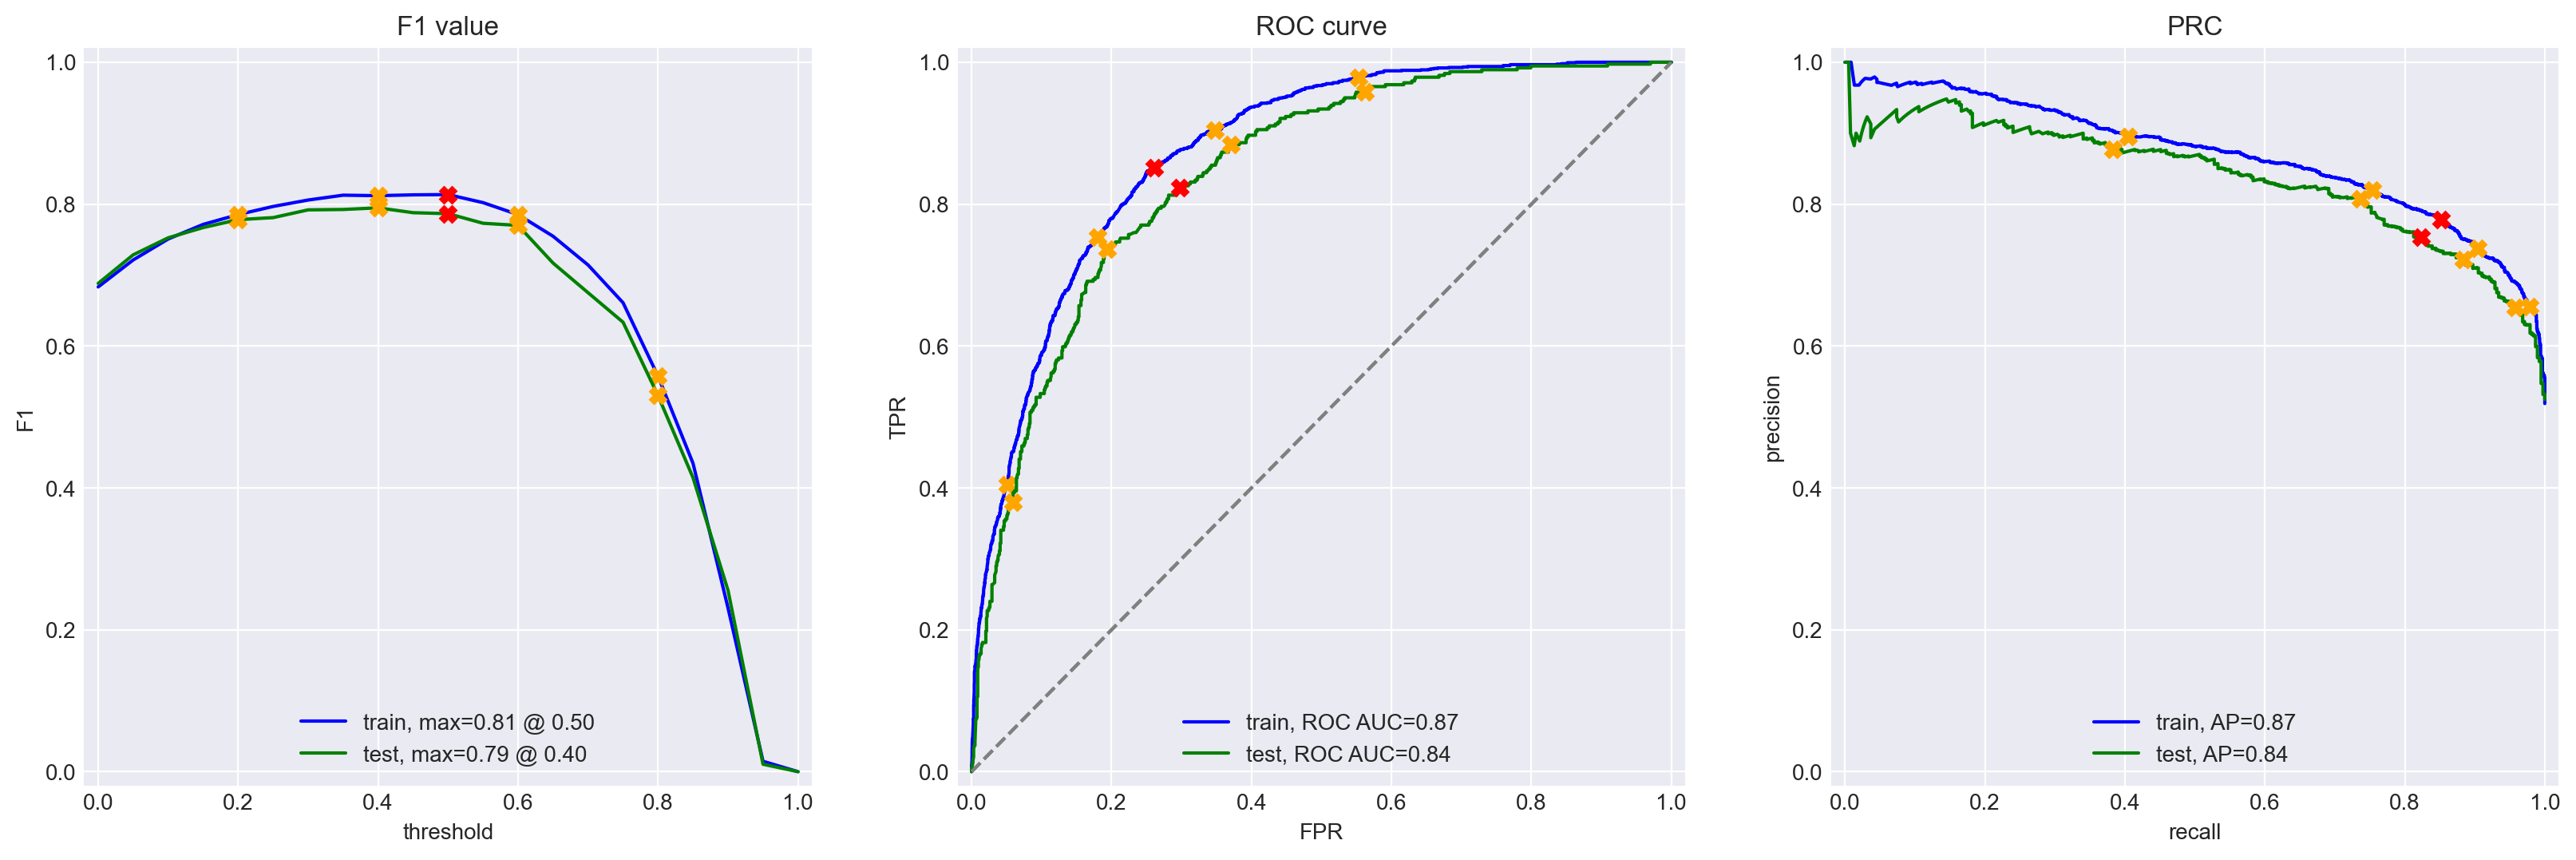

In [144]:
# train LightGBM model with the best hyperparameters
model_lgbm = LGBMClassifier(random_state=12345, learning_rate=0.05, n_estimators=100, num_leaves=10, objective='binary')
model_lgbm.fit(X_train_boost_ups, Y_train_boost_ups)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_lgbm, X_train_boost_ups, Y_train_boost_ups, X_test_boost_ups, Y_test_boost_ups)

With the LightGradientBoostingMachine model there is the highest ROC-AUC so far for the train set but with a light overfit due to the fact that the ROC-AUC is lower in the test set. Still, LGBM model does not reach the desired ROC-AUC performance.

In [199]:
# Save info
model = {'model': 'LGBMClassifier',
        'roc_auc_train': 0.875, 
        'roc_auc_test':0.845, 
        'accuracy_train':0.797,
        'accuracy_test':0.766,
        'training_time': 4.16}

summary_models = summary_models.append(model, ignore_index = True)

### 6.6 Model_5 - CatBoostClassifier <a id='6.6'></a>

First, we look for the best parameters to use in the prediction model. We use OneHotEncoding and the parameter auto_class_weights='Balanced' to balance the target.

In [145]:
# set different hyperparameters
params_cbc = {
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# calling GridSearchCV to get hyperparameters that maximize ROC-AUC
cat_boost = GridSearchCV(CatBoostClassifier(random_state=12345, auto_class_weights='Balanced'),
                    param_grid=params_cbc,
                    scoring='roc_auc',
                    verbose=False,
                    cv=5
                    )

# train the model for hyperparameter fitting
start_time = time.time()
cat_boost.fit(X_train_ohe, Y_train_ohe, verbose=False)
train_time = time.time() - start_time

print(f'Best hyperparameters CatBoost: {cat_boost.best_params_}')
print(f'Best ROC-AUC value CatBoost: {cat_boost.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters CatBoost: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
Best ROC-AUC value CatBoost: 0.849
training time = 1037.48 sec


           train   test
Accuracy   0.798  0.766
Recall     0.856  0.826
Precision  0.777  0.752
F1         0.814  0.787
APS        0.869  0.838
ROC AUC    0.874  0.845


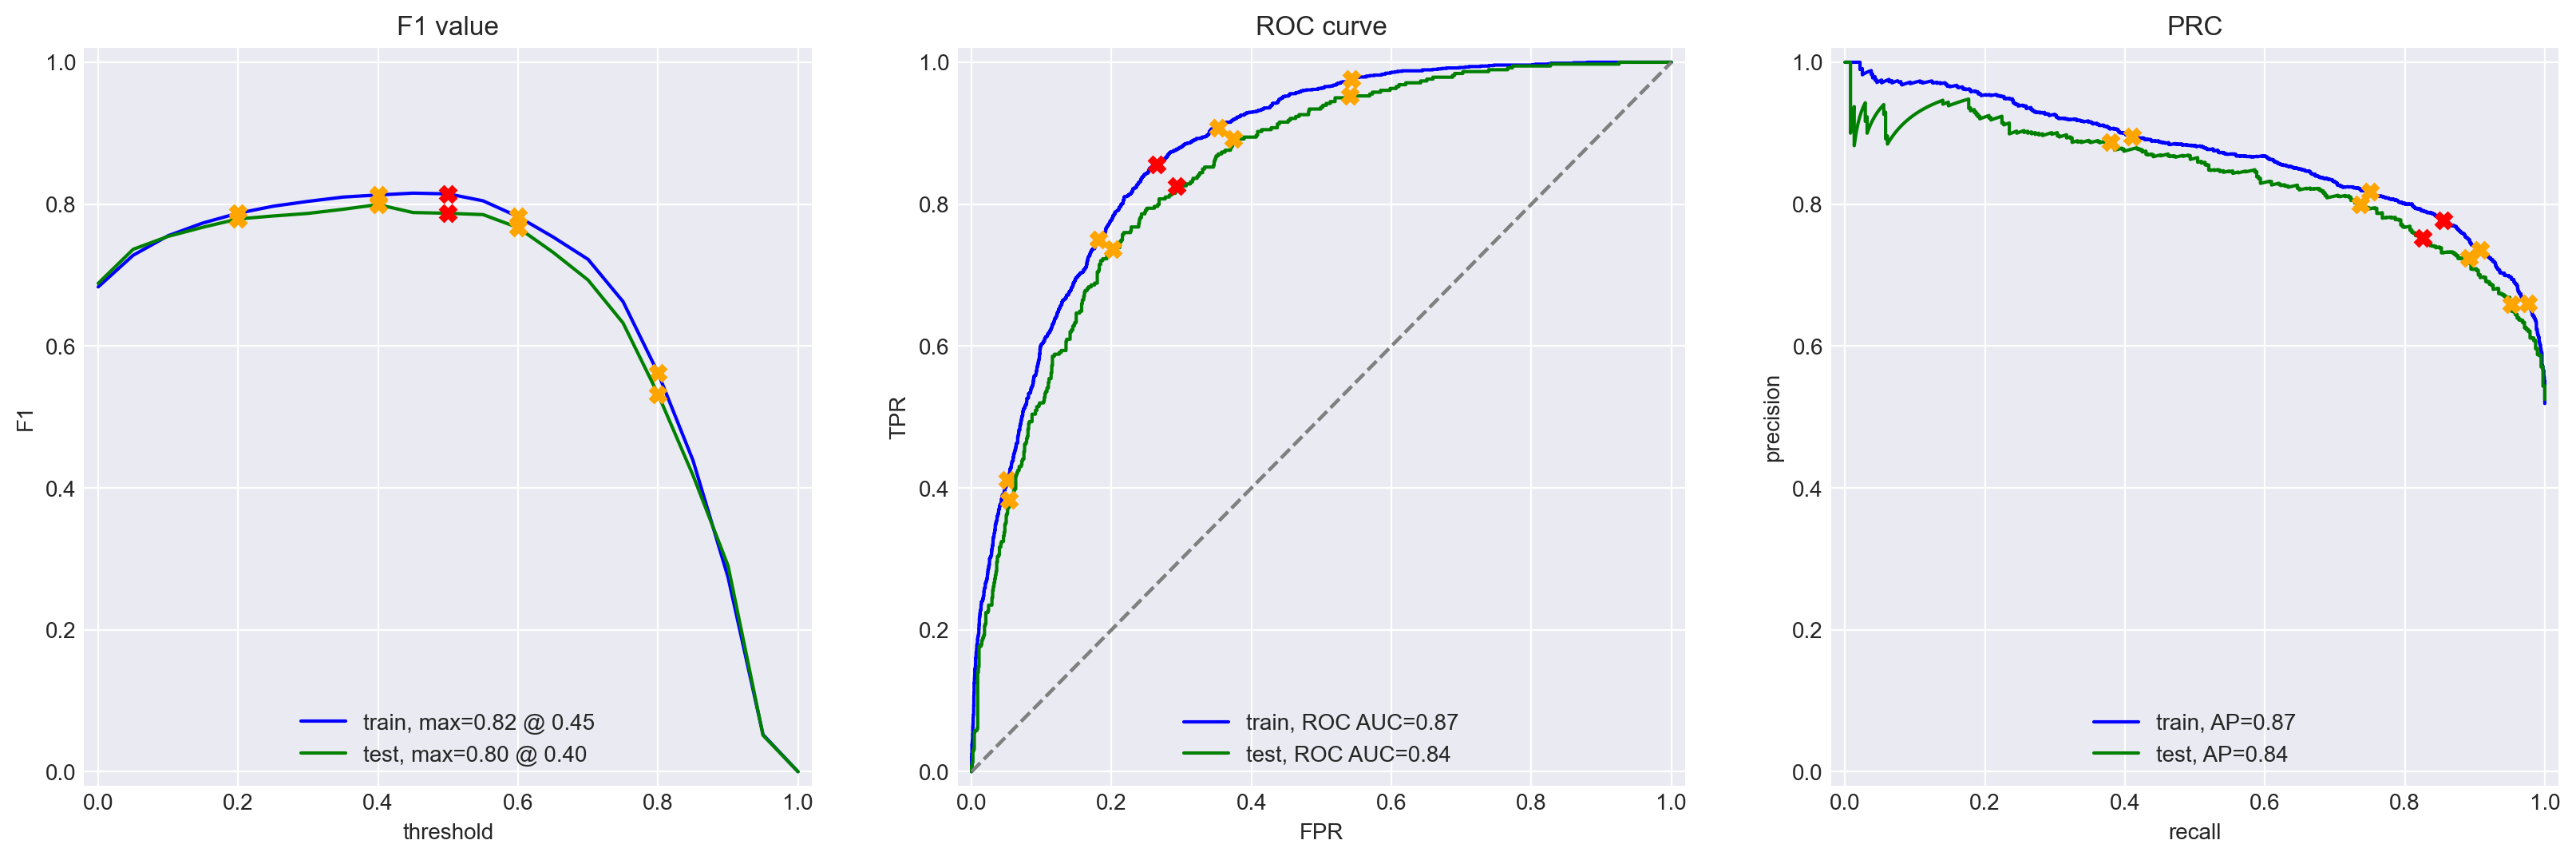

In [146]:
# train CatBoost model with the best hyperparameters
model_cbc = CatBoostClassifier(random_state=12345, depth=4, l2_leaf_reg= 3, learning_rate=0.01)
model_cbc.fit(X_train_ohe_ups, Y_train_ohe_ups, verbose=False)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_cbc, X_train_ohe_ups, Y_train_ohe_ups, X_test_ohe_ups, Y_test_ohe_ups)

CatBoostClassifier does not offer much improvement compared with LightGBM, so we skip to the next one.

In [201]:
# Save info
model = {'model': 'CatBoostClassifier',
        'roc_auc_train': 0.874, 
        'roc_auc_test':0.845, 
        'accuracy_train':0.798,
        'accuracy_test':0.766,
        'training_time': 1037}

summary_models = summary_models.append(model, ignore_index = True)

### 6.7 Model_6 - XGBoostClassifier <a id='6.7'></a>

First, we look for the best parameters to use in the prediction model. In this case, we use the parameter scale_pos_weight=3 to balance data.

In [147]:
# set different hyperparameters
params_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01,0.05,0.1],
    'n_estimators': [50, 100],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5]
}

# calling GridSearchCV to get hyperparameters that maximize ROC-AUC
xgb = GridSearchCV(XGBClassifier(random_state=12345, scale_pos_weight=3),
                    param_grid=params_xgb,
                    scoring='roc_auc',
                    cv=5
                    )

# train the model for hyperparameter fitting
start_time = time.time()
xgb.fit(X_train_ohe, Y_train_ohe)
train_time = time.time() - start_time

print(f'Best hyperparameters XGBoost: {xgb.best_params_}')
print(f'Best ROC-AUC value XGBoost: {xgb.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters XGBoost: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 5}
Best ROC-AUC value XGBoost: 0.847
training time = 1203.35 sec


           train   test
Accuracy   0.796  0.762
Recall     0.851  0.818
Precision  0.777  0.751
F1         0.812  0.783
APS        0.871  0.835
ROC AUC    0.877  0.842


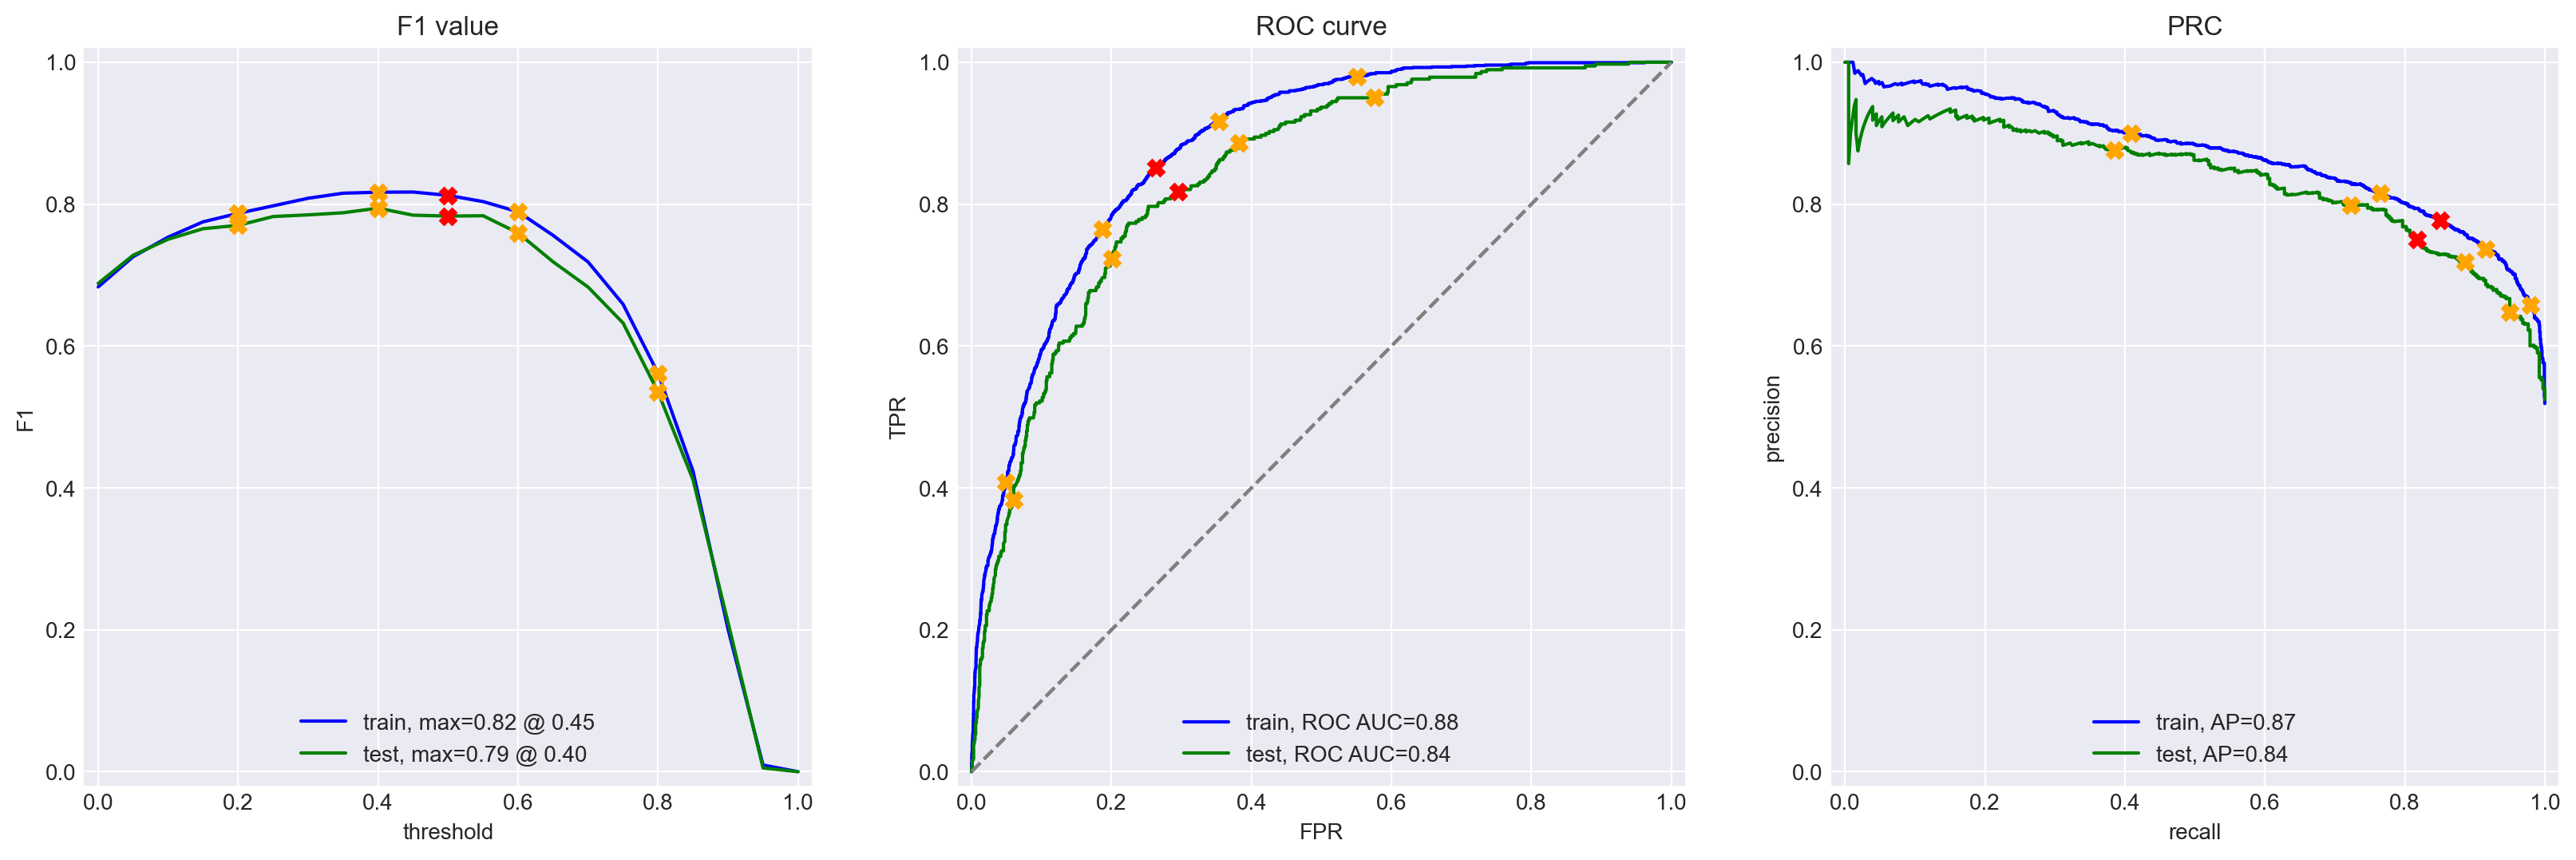

In [148]:
# train XGBM model with the best hyperparameters
model_xgb = XGBClassifier(random_state=12345, gamma=0.5, learning_rate=0.1, max_depth=4, n_estimators=50, reg_alpha=0.5, reg_lambda=5)
model_xgb.fit(X_train_ohe_ups, Y_train_ohe_ups)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_xgb, X_train_ohe_ups, Y_train_ohe_ups, X_test_ohe_ups, Y_test_ohe_ups)

For XGBoostClassifier, behaviour is pretty similar to the last two models analyzed. We did not reach the desired ROC-AUC

In [203]:
# Save info
model = {'model': 'XGBClassifier',
        'roc_auc_train': 0.877, 
        'roc_auc_test':0.842, 
        'accuracy_train':0.796,
        'accuracy_test':0.762,
        'training_time': 1200}

summary_models = summary_models.append(model, ignore_index = True)

### 6.8 Model_7 - MPLClassifier <a id='6.8'></a>

Lets rely on a easy neural network called Multilayer Perceptron classifier. This can be used to solve complex nonlinear problems. It handles large amounts of input data well.

In [149]:
# set different hyperparameters
param_mlp = {
    'hidden_layer_sizes': [(100,50,30)],
    'max_iter': [50, 100, 150],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# calling GridSearchCV to get hyperparameters that maximize ROC-AUC
mlp_class = GridSearchCV(MLPClassifier(), param_grid=param_mlp, scoring='roc_auc', cv=5)

start_time = time.time()
mlp_class.fit(X_train_ohe, Y_train_ohe)
train_time = time.time() - start_time

print(f'Best hyperparameters MultiLayer Perceptron: {mlp_class.best_params_}')
print(f'Best ROC-AUC value MultiLayer Perceptron: {mlp_class.best_score_.round(3)}')
print('training time = 'f'{train_time:.2f} sec')

Best hyperparameters MultiLayer Perceptron: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'adam'}
Best ROC-AUC value MultiLayer Perceptron: 0.839
training time = 713.83 sec


           train   test
Accuracy   0.801  0.781
Recall     0.499  0.485
Precision  0.664  0.620
F1         0.570  0.544
APS        0.664  0.624
ROC AUC    0.846  0.831


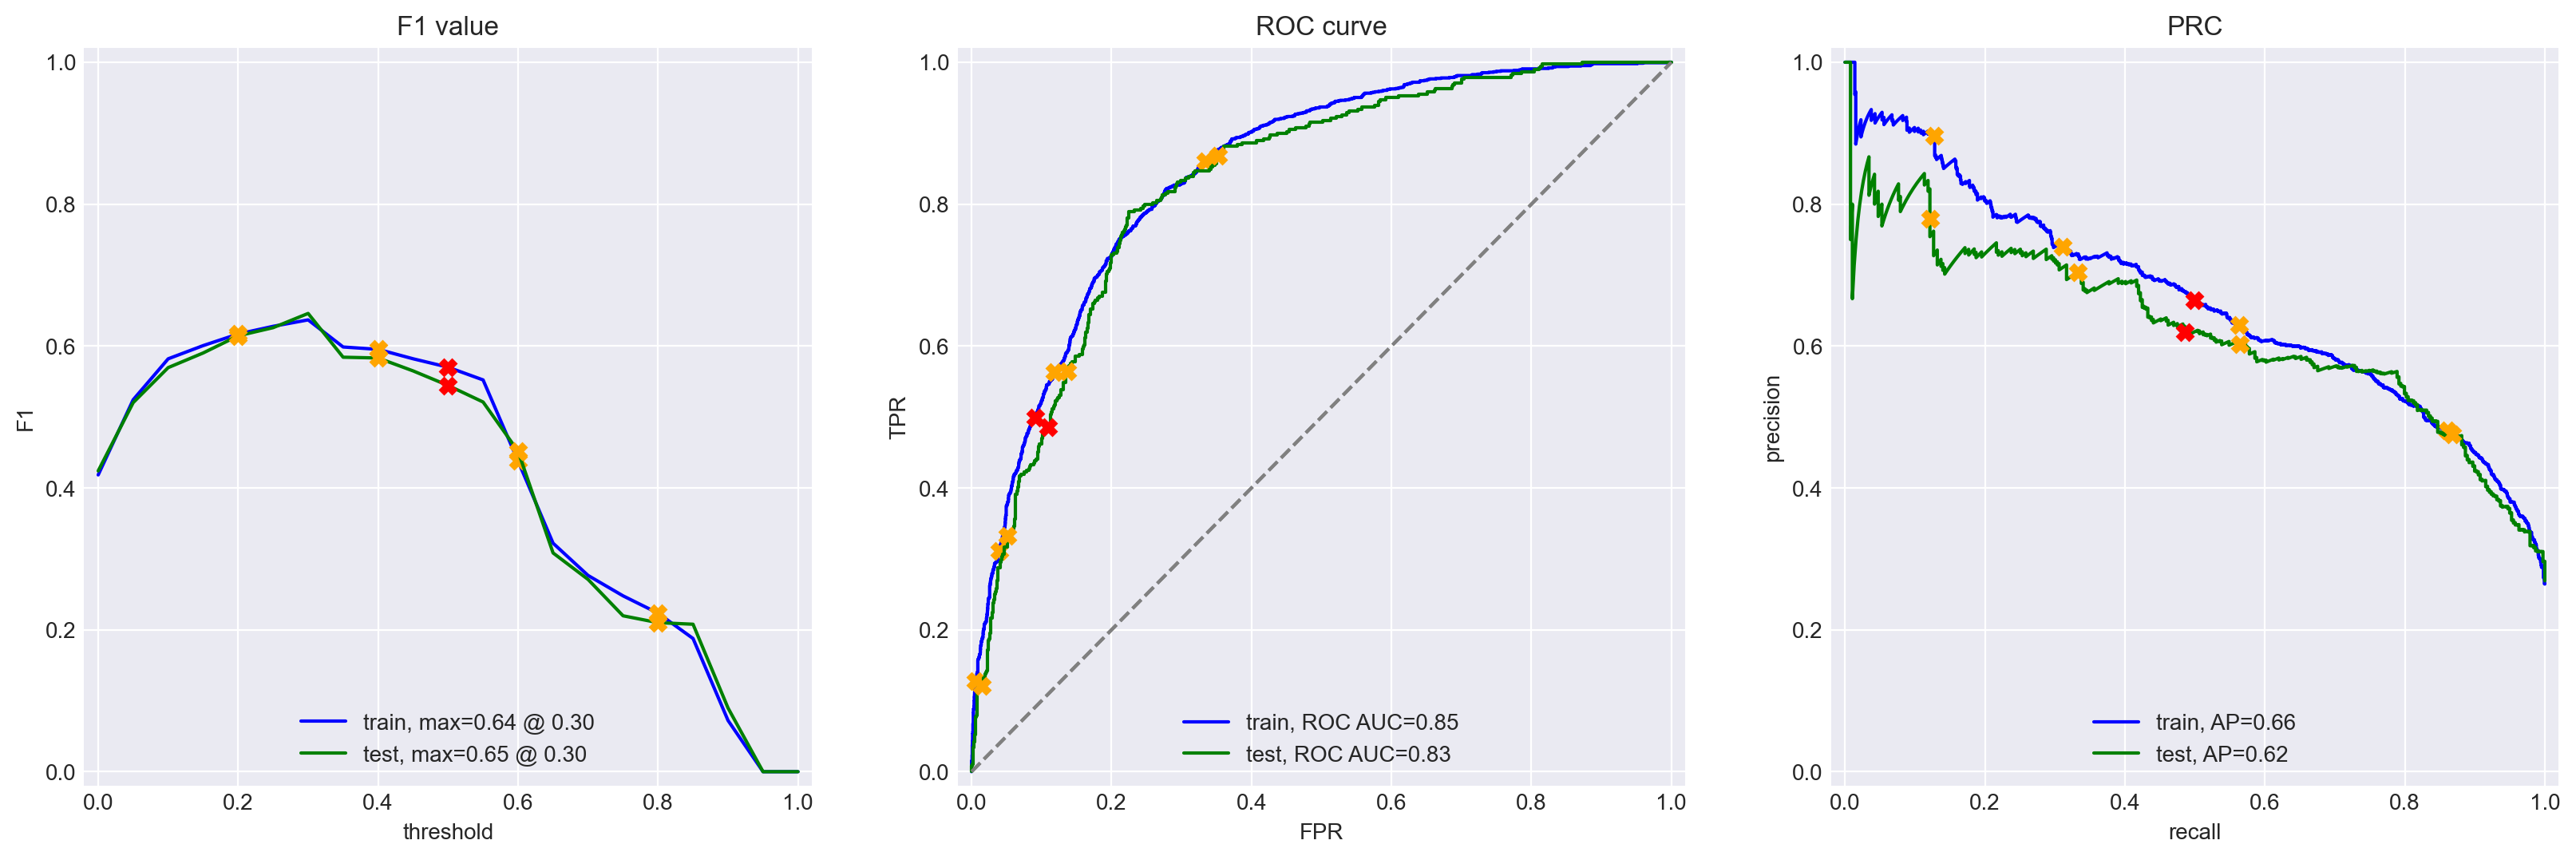

In [79]:
model_mlp = MLPClassifier(activation='tanh', 
                    alpha=0.05, 
                    hidden_layer_sizes=(100, 50, 30), 
                    learning_rate='constant',
                    max_iter=100,
                    solver='adam')
model_mlp.fit(X_train_ohe, Y_train_ohe)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_mlp, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe)

No further improvement given by this deep learning technique. The overfit is slightly smaller though.

In [205]:
# Save info
model = {'model': 'MLPClassifier',
        'roc_auc_train': 0.846, 
        'roc_auc_test':0.831, 
        'accuracy_train':0.801,
        'accuracy_test':0.781,
        'training_time': 713}

summary_models = summary_models.append(model, ignore_index = True)

## Stage 7. Models comparison <a id='7'></a>

Let's now make in a table with all the values that we got:

In [206]:
summary_models

,model,roc_auc_train,roc_auc_test,accuracy_train,accuracy_test,training_time
0,DummyClassifier,0.500,0.500,0.736,0.731,0
1,DecisionTreeClassifier,0.849,0.823,0.768,0.754,0.76
2,RandomForestClassifier,0.867,0.841,0.788,0.767,18.5
3,LogisticRegression,0.840,0.840,0.760,0.763,3.12
4,LGBMClassifier,0.875,0.845,0.797,0.766,4.16
5,CatBoostClassifier,0.874,0.845,0.798,0.766,1037
6,XGBClassifier,0.877,0.842,0.796,0.762,1200
7,MLPClassifier,0.846,0.831,0.801,0.781,713


To have a more explicit view, we plot the previous table in a bar chart

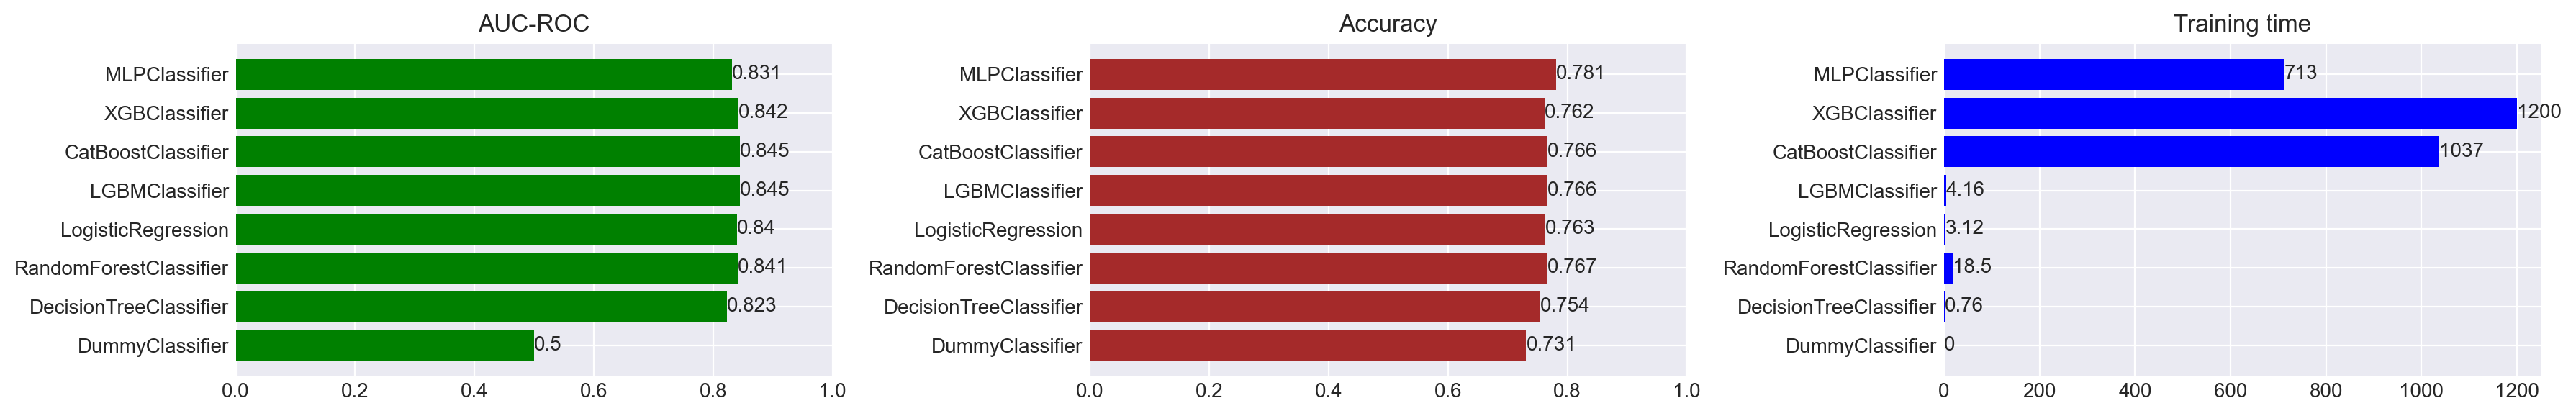

In [234]:
fig, ax = plt.subplots(1, 3, figsize=(18,3))

ax1 = ax[0]
bars = ax1.barh(summary_models['model'], summary_models['roc_auc_test'], color=['green'])
ax1.bar_label(bars)
ax1.set_xlim(0, 1)
ax1.set_title('AUC-ROC')

ax2 = ax[1]
bars = ax2.barh(summary_models['model'], summary_models['accuracy_test'], color=['brown'])
ax2.bar_label(bars)
ax2.set_xlim(0, 1)
ax2.set_title('Accuracy')

ax3 = ax[2]
bars = ax3.barh(summary_models['model'], summary_models['training_time'], color=['blue'])
ax3.bar_label(bars)
ax3.set_xlim(0, 1250)
ax3.set_title('Training time')

fig.tight_layout()

So, the best model overall (considering also CPU time) is MLPClassifier. Since it is not easy to get the features importance with neural network, we get those of the XGBClassifier

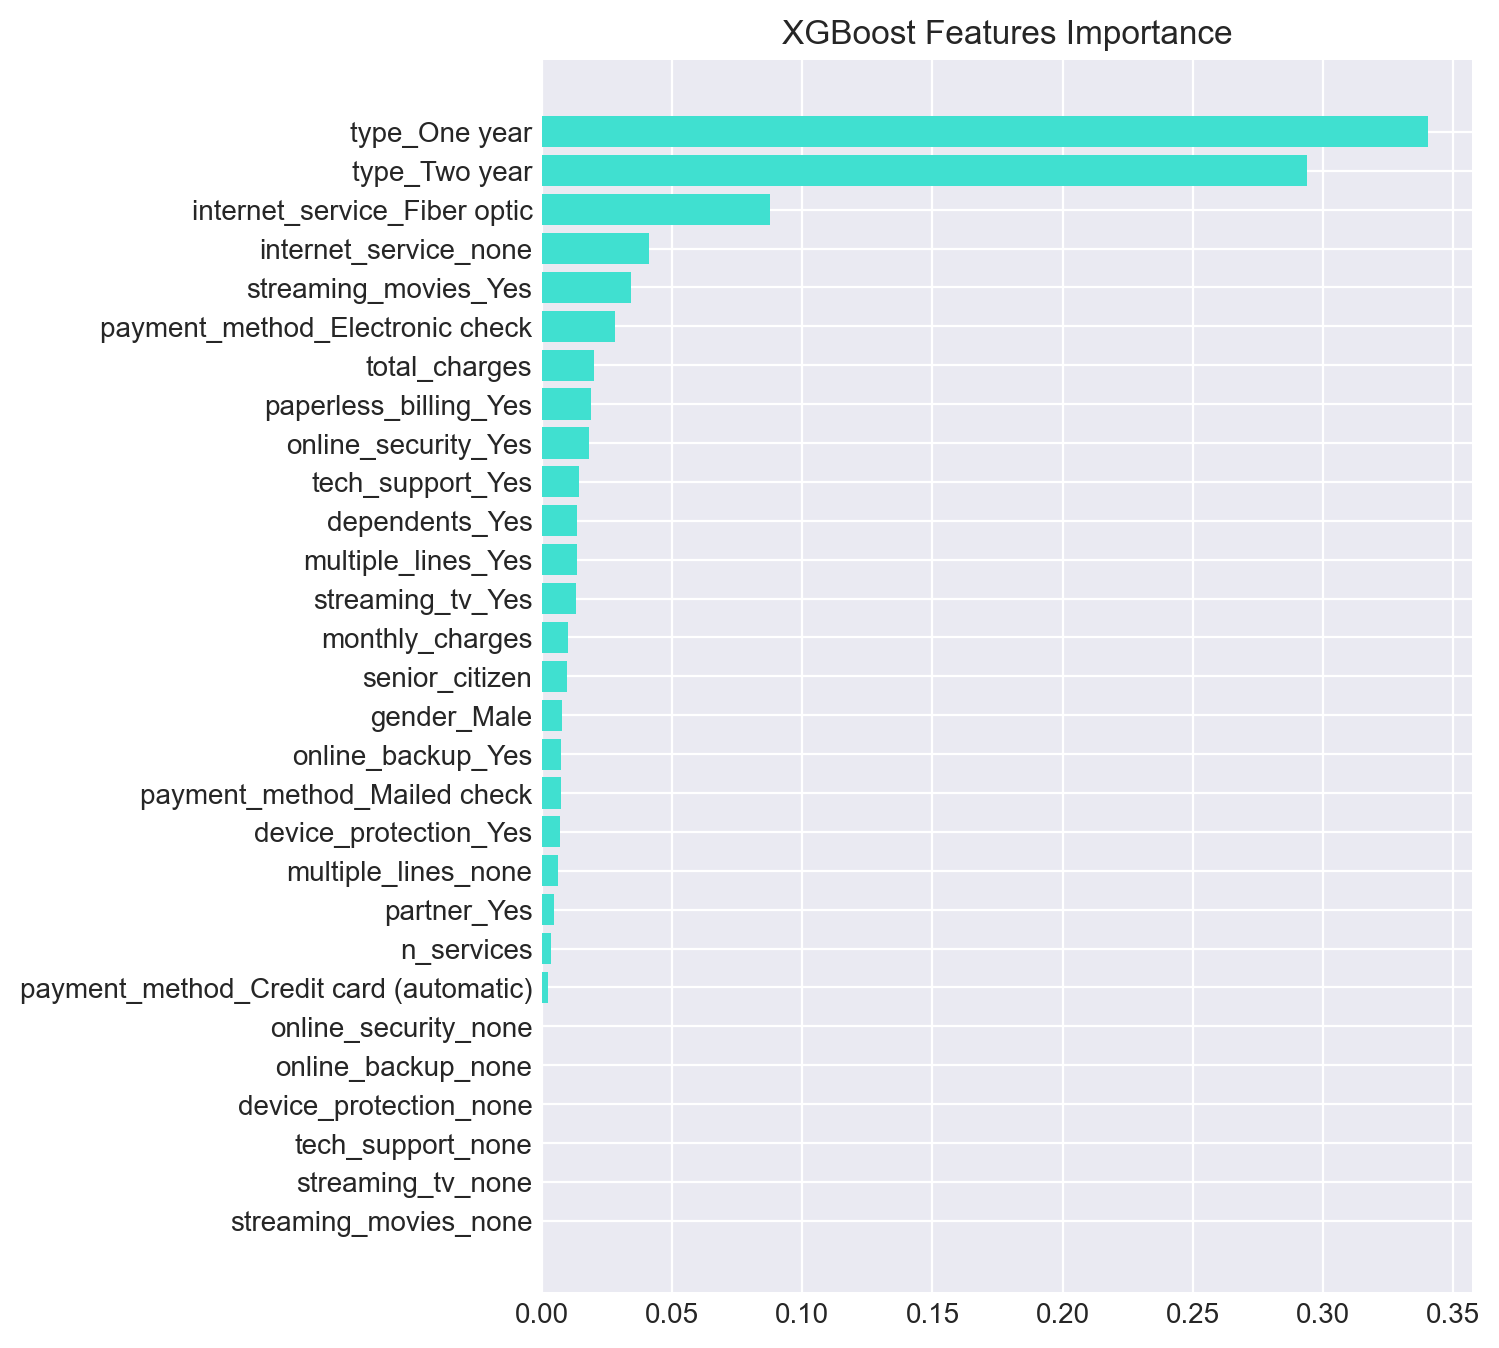

In [236]:
# plot features importance
sorted_feature_importance = model_xgb.feature_importances_.argsort()
plt.figure(figsize=(6,8))
plt.barh(X_train_ohe.columns[sorted_feature_importance], 
     model_xgb.feature_importances_[sorted_feature_importance], 
     color='turquoise')
plt.title(f'XGBoost Features Importance')
plt.show()

These are the features that the model considers the most to understand what class the client belongs.

We can confirm that for both the AUC-ROC and accuracy, all models have passed the sanity test and are better than randomness. However, none of the models reached the target of AUC-ROC ≥ 0.88 established at the beginning.
We can see differences in the performance of each model, so that basic models such as DecisionTree or RandomForest presented lower AUC-ROC than gradient boosting models. There are three most important features construction: type_two year, type_one year and internet_service_fiber optic.

## Conclusions <a id='conclusion'></a>

We started our project with the aim of forecasting a client churn so that the telecom operator can offer promotional codes and special plans.

Interconnect provided us with four dataset that, once preprocessed and merged, formed a 7043 rows and 19 column dataset.

We ran an exploratory data analysis to get aware of what we are dealing with and eventually executed a small hypotesis testing comparing some features of leaving and not-leaving customers.

We prepared the data for model training and created a function to evaluate each model, 8 in total.

We realized that the best model is MLPlassifier and upon this we got a list of the most important features to consider when dealing with a potential customer churn.

_______________

## Report <a id='report'></a>

This work addressed the problem of contract cancellation by the clients of the telecom operator Interconnect. Since, according to the exploratory data analysis (EDA), the company's contract cancellation rate was 27%, the main goal was to build a model that predicts future contract cancellations.

The data provided by the company consist of 4 datasets:
- `contract.csv`- contract information
- `personal.csv` - personal data of the clients
- `internet.csv` - information about Internet services
- `phone.csv` - information about phone services

All those dataframe refer to the period 2013-2020 and everyone contain the column 'customerID' that helped us when we merged all them in one general dataframe

Telecom operator Interconnect mainly provides two types of services:
- `Communication by landline`. The phone can be connected to several lines simultaneously.
- `Internet`. The network can be set up over a telephone line (DSL, Digital Subscriber Line) or over a fiber optic cable.

There are also extra services:
- `Internet security`. antivirus software (DeviceProtection) and a blocker of malicious websites (OnlineSecurity).
- `Technical support line` (TechSupport).
- `File storage` in the cloud and data backup (OnlineBackup).
- `Streaming TV` (StreamingTV).
- `Streaming Movies` (StreamingMovies).


Customers can choose between a monthly payment or sign a contract of 1 or 2 years. They can choose for various payment methods and receive an electronic invoice.

Milestones of this project were:
- Exploring initial data and understanding all services offered by the company
- Preparing data
- Graphical data exploration and thus understanding the dynamics of Interconnect's business and contract cancellations
- Data preparation for modeling (features selection and encoding of categorical variables)
- Data splitting (train, test, and validation set), standardization
- Finding which model better predicts the customer churn, taking into account ROC-AUC metrics and F1

The models analysed were: 
- `DummyClassifier`
- `DecisionTree`
- `RandomForest`
- `LogisticRegression`
- `LGBMClassifier`
- `CatBoostClassifier`
- `XGBoostClassifier`
- `MPLClassifier`

The final model that has the best compromise is MLPClassifier, which obtained an AUC-ROC of 0.846 and an accuracy of 0.781, with the best hyperparameters being: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'adam'}

With a ROC-AUC of 85% and a accuracy of 78%, our model can detect those clients who are more likely to quit their subscription, thus aiming advertisements and offers to the right user, reducing expenses on marketing strategies.

_____________